In [523]:
midx = '56'

# pytorch models with folds

mnames = ['iv3_q11','irv2_q10','resnet_q24','resnet_q25','resnet_q40',
          'gap_q12','nas_q11','se_resnext_q26','se_resnext_q28',
          'bni_q0','bni_q1']

mnames += ['iv3_q12','iv3_u11','iv3_u12',
           'resnet_q26','resnet_q27',
           'resnet_u25','resnet_u31','resnet_u56','resnet_u60',
           'resnet_u101',
           'gap_u14','bni_u1','bni_u2']

# mnames = ['iv3_q11','irv2_q10',
#            'resnet_q24','resnet_q25','resnet_q26','resnet_q27',
#            'resnet_q40',
#            'resnet_u25',
#            'gap_q12','nas_q11','nas_q12',
#            'se_resnext_q26','se_resnext_q28',
#            'bni_q0','bni_q1']

special = 'resnet_u60'

olist = []

gpct = 90.
gscale = 10.
nfold = 4

In [524]:
import numpy as np
import pandas as pd
import pickle
import os
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Reshape, Lambda, Activation
from keras.layers import UpSampling2D, Dropout, BatchNormalization, MaxPooling2D
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.applications import MobileNet

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.morphology import opening, closing

from scipy.special import logit, expit
import scipy.optimize as opt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import gc
import cv2
from tqdm import tqdm_notebook

from sklearn.metrics import jaccard_similarity_score, f1_score, precision_score, recall_score

# from metrics import iou_metric, iou_metric_batch
# from metric import mean_iou

In [525]:
PATH_TO_TRAIN = './train/'
PATH_TO_TEST = './test/'
PATH_TO_TARGET = './train.csv'
PATH_TO_SUB = './sample_submission.csv'

LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

In [526]:
df = pd.read_csv(PATH_TO_TARGET)
df.set_index('Id',inplace=True)
print(df.head())
print(df.shape)

                                       Target
Id                                           
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18
(31072, 1)


In [527]:
file_list = list(df.index.values)

ss = pd.read_csv(PATH_TO_SUB)
ss.set_index('Id',inplace=True)
print(ss.head())
print(ss.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [528]:
# train_df["images"] = [np.array(load_img("images/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                       for idx in tqdm_notebook(train_df.index)]

# train_df["masks"] = [np.array(load_img("masks/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                      for idx in tqdm_notebook(train_df.index)]

In [529]:
df.columns

Index(['Target'], dtype='object')

In [530]:
# estimate thresholds by line search
def F1_hard(preds, targs, th=0.5):
    return -f1_score(targs,  (preds>th).astype(int))

def fit_val1(x, y, start=0.5):
    params = np.array([start])
    wd = 1e-5
#     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
    error = lambda p: np.array(F1_hard(x,y,p))
    p = opt.minimize_scalar(error, bounds=[0.3,0.7], method='bounded').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
    return p

In [531]:
oof = df.copy()
# print(oof.head())
# print(oof.shape)
eps = 1e-6
num_classes = 28
np.set_printoptions(precision=3,linewidth=80,suppress=True)

for k,m in enumerate(mnames):
    print(' ')
    print(m)
    first = True
    for fold in range(nfold):
        idf, pooff, yooff = pickle.load(open('oof/'+m+'_'+str(fold)+'.pkl','rb'))
        
        # change to probability scale
        # reduce map to single number
        if m in olist: 
            pooff = expit(pooff)
        else: 
            pooff = np.percentile(pooff, gpct, axis=(2,3))
            pooff = 1./(1. + np.exp(-pooff/gscale))
            
        if first:
            id = idf
            poof = pooff.copy()
            yoof = yooff.copy()
            first = False
        else:
            id = id + idf
            poof = np.concatenate((poof,pooff))
            yoof = np.concatenate((yoof,yooff))
    
#     # determine class-specific thresholds and convert predictions to binary
#     th = np.zeros(num_classes)
#     for i in range(num_classes):
#         th[i] = fit_val1(poof[:,i],yoof[:,i])
#     print('Thresholds: ',th)
#     poof = poof > th
#     print('F1 macro: ',f1_score(yoof, poof, average='macro'))

    mdf = pd.DataFrame({'Id':id})
    # print(poof.shape)
    if k==0: mdf['y'] = [yoof[i] for i in range(yoof.shape[0])]
    mdf[m] = [poof[i] for i in range(poof.shape[0])]
    mdf.set_index('Id',inplace=True)
    oof = oof.join(mdf)

 
iv3_q11
 
irv2_q10
 
resnet_q24
 
resnet_q25
 
resnet_q40
 
gap_q12
 
nas_q11
 
se_resnext_q26
 
se_resnext_q28
 
bni_q0
 
bni_q1
 
iv3_q12
 
iv3_u11
 
iv3_u12
 
resnet_q26
 
resnet_q27
 
resnet_u25
 
resnet_u31
 
resnet_u56
 
resnet_u60
 
resnet_u101
 
gap_u14
 
bni_u1
 
bni_u2


In [532]:
# print(oof.head())
print(oof.shape)

(31072, 26)


In [533]:
oof.columns

Index(['Target', 'y', 'iv3_q11', 'irv2_q10', 'resnet_q24', 'resnet_q25',
       'resnet_q40', 'gap_q12', 'nas_q11', 'se_resnext_q26', 'se_resnext_q28',
       'bni_q0', 'bni_q1', 'iv3_q12', 'iv3_u11', 'iv3_u12', 'resnet_q26',
       'resnet_q27', 'resnet_u25', 'resnet_u31', 'resnet_u56', 'resnet_u60',
       'resnet_u101', 'gap_u14', 'bni_u1', 'bni_u2'],
      dtype='object')

In [534]:
vp = oof.loc[oof['y'].notnull()]
print(vp.shape)

(31072, 26)


In [535]:
# # compute rank transform separately for every column
# from scipy.stats import rankdata
# n = vp.shape[0] * 28
# for m in mnames:
#     a = rankdata(np.array(list(vp[m])).flatten()).reshape((vp.shape[0],28))/n
#     vp[m] = [i for i in a]
# print(vp.shape)

In [536]:
vp.head()

Target  \
Id                                              
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18   

                                                                                      y  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                                iv3_q11  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.6349612911071786, 0.3335005806696897, 0.415...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5398508787714067, 0.7151756958335682, 0.450...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.5963852726886236, 0.36781641616587707, 0.49...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.5399356774238568, 0.6818624411912063, 0.434...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.5191876269250988, 0.41060182930770617, 0.48...   

                                                                               irv2_q10  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.5344023112863627, 0.33976740976571396, 0.44...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5383846662539561, 0.5707782011700546, 0.510...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.5418327576812514, 0.36512268906905015, 0.48...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.5223155595917686, 0.571533169733108, 0.3854...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.49681146183175534, 0.39463813206025294, 0.4...   

                                                                             resnet_q24  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.5462745900848558, 0.3490719241389025, 0.471...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5112971555397656, 0.5753917069594046, 0.472...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.5310493318135783, 0.340147084097598, 0.4858...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.5130285090051543, 0.5849133683591821, 0.388...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.4950374388856521, 0.36853584061976824, 0.48...   

                                                                             resnet_q25  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.5476780995164268, 0.3415807138523649, 0.460...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5029610384545147, 0.5574916385428522, 0.452...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.528092394672466, 0.35272254334729614, 0.469...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.5277645506409527, 0.5646834277453082, 0.361...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.5086226191547994, 0.3650864454984731, 0.444...   

                                                                             resnet_q40  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.548971323902085, 0.3950417678318714, 0.4471...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5187967865947322, 0.580001929360135, 0.4498...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.5226366374559694, 0.3626791456192704, 0.475...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.523658207

In [537]:
offset = 2
nm = vp.shape[1] - offset
print(offset, nm)

2 24


In [538]:
y = np.array([a for a in vp.y])
y.shape

(31072, 28)

In [539]:
ys = np.sum(y,axis=1)
print(ys.shape)
print(ys.min(),ys.mean(),ys.max())

(31072,)
1.0 1.6343331 5.0


In [540]:
c_val = np.sum(y,axis=0)
for k,v in LABEL_MAP.items():
    print(k,v, 'count', c_val[k],
             'prop', '%6.4f' % (c_val[k]/y.shape[0]))

0 Nucleoplasm count 12885.0 prop 0.4147
1 Nuclear membrane count 1254.0 prop 0.0404
2 Nucleoli count 3621.0 prop 0.1165
3 Nucleoli fibrillar center count 1561.0 prop 0.0502
4 Nuclear speckles count 1858.0 prop 0.0598
5 Nuclear bodies count 2513.0 prop 0.0809
6 Endoplasmic reticulum count 1008.0 prop 0.0324
7 Golgi apparatus count 2822.0 prop 0.0908
8 Peroxisomes count 53.0 prop 0.0017
9 Endosomes count 45.0 prop 0.0014
10 Lysosomes count 28.0 prop 0.0009
11 Intermediate filaments count 1093.0 prop 0.0352
12 Actin filaments count 688.0 prop 0.0221
13 Focal adhesion sites count 537.0 prop 0.0173
14 Microtubules count 1066.0 prop 0.0343
15 Microtubule ends count 21.0 prop 0.0007
16 Cytokinetic bridge count 530.0 prop 0.0171
17 Mitotic spindle count 210.0 prop 0.0068
18 Microtubule organizing center count 902.0 prop 0.0290
19 Centrosome count 1482.0 prop 0.0477
20 Lipid droplets count 172.0 prop 0.0055
21 Plasma membrane count 3777.0 prop 0.1216
22 Cell junctions count 802.0 prop 0.0258
23

In [541]:
# idx = range(28)
# loc = [LABEL_MAP[j] for j in idx]
# lb = [c_val[j]/y.shape[0] for j in idx]

# df = pd.DataFrame({'idx':idx, 'loc':loc, 'training':lb})
# fname = 'train_props.csv'
# df.to_csv(fname,index=False)
# print(fname)

In [542]:
# train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
# _ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [543]:
ymean = np.mean(y,axis=0)
print(ymean)

[0.415 0.04  0.117 0.05  0.06  0.081 0.032 0.091 0.002 0.001 0.001 0.035 0.022
 0.017 0.034 0.001 0.017 0.007 0.029 0.048 0.006 0.122 0.026 0.095 0.01  0.265
 0.011 0.   ]


(-0.03034705803458428, 0.4436122904074585)

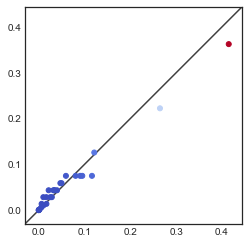

In [544]:
# plot training class frequencies versus those from leaderboard probing by iafoss
lb_prob = np.array([
0.36239782, 0.043841336, 0.075268817, 0.059322034, 0.075268817,
0.075268817, 0.043841336, 0.075268817, 0.0018, 0.0014,
0.0009, 0.043841336, 0.043841336, 0.014198783, 0.043841336,
0.0007, 0.028806584, 0.014198783, 0.028806584, 0.059322034,
0.0056, 0.126126126, 0.028806584, 0.075268817, 0.0104,
0.222493888, 0.028806584, 0.0004
])
   
# sns.regplot(ymean, lb_prob)

c = ymean**2 + lb_prob**2

fig, ax = plt.subplots()
ax.scatter(ymean, lb_prob, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [545]:
# lb probing resuluts from iafoss
# print lower and upper bound on frequencies
probe = {
0 : 0.019,
1 : 0.003,
2 : 0.005,
3 : 0.004,
4 : 0.005,
5 : 0.005,
6 : 0.003,
7 : 0.005,
8 : 0.000,
9 : 0.000,
10 : 0.000,
11 : 0.003,
12 : 0.003,
13 : 0.001,
14 : 0.003,
15 : 0.000,
16 : 0.002,
17 : 0.001,
18 : 0.002,
19 : 0.004,
20 : 0.000,
21 : 0.008,
22 : 0.002,
23 : 0.005,
24 : 0.000,
25 : 0.013,
26 : 0.002,
27 : 0.000
}

r = 0.000499
for k in range(28):

    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    print(k,'%6.4f %6.4f %6.4f' % (fi0,fi,fi1),LABEL_MAP[k])

0 0.3496 0.3624 0.3755 Nucleoplasm
1 0.0363 0.0438 0.0515 Nuclear membrane
2 0.0673 0.0753 0.0834 Nucleoli
3 0.0515 0.0593 0.0672 Nucleoli fibrillar center
4 0.0673 0.0753 0.0834 Nuclear speckles
5 0.0673 0.0753 0.0834 Nuclear bodies
6 0.0363 0.0438 0.0515 Endoplasmic reticulum
7 0.0673 0.0753 0.0834 Golgi apparatus
8 0.0000 0.0000 0.0070 Peroxisomes
9 0.0000 0.0000 0.0070 Endosomes
10 0.0000 0.0000 0.0070 Lysosomes
11 0.0363 0.0438 0.0515 Intermediate filaments
12 0.0363 0.0438 0.0515 Actin filaments
13 0.0071 0.0142 0.0214 Focal adhesion sites
14 0.0363 0.0438 0.0515 Microtubules
15 0.0000 0.0000 0.0070 Microtubule ends
16 0.0215 0.0288 0.0363 Cytokinetic bridge
17 0.0071 0.0142 0.0214 Mitotic spindle
18 0.0215 0.0288 0.0363 Microtubule organizing center
19 0.0515 0.0593 0.0672 Centrosome
20 0.0000 0.0000 0.0070 Lipid droplets
21 0.1173 0.1261 0.1351 Plasma membrane
22 0.0215 0.0288 0.0363 Cell junctions
23 0.0673 0.0753 0.0834 Mitochondria
24 0.0000 0.0000 0.0070 Aggresome
25 0.2121

In [546]:
w = 1.0/np.mean(y,axis=0)
np.set_printoptions(precision=4,linewidth=80,suppress=True)
print(w)
print(w/sum(w))

[   2.4115   24.7783    8.5811   19.9052   16.7234   12.3645   30.8254
   11.0106  586.2642  690.4889 1109.7142   28.4282   45.1628   57.8622
   29.1482 1479.6191   58.6264  147.9619   34.4479   20.9663  180.6512
    8.2266   38.7431   10.4796   96.4969    3.7764   94.7317 2824.727 ]
[0.0003 0.0032 0.0011 0.0026 0.0022 0.0016 0.004  0.0014 0.0764 0.09   0.1446
 0.0037 0.0059 0.0075 0.0038 0.1928 0.0076 0.0193 0.0045 0.0027 0.0235 0.0011
 0.005  0.0014 0.0126 0.0005 0.0123 0.3681]


In [547]:
wc = np.clip(w,0.,1000.)
print(wc)
print(wc/sum(wc))

[   2.4115   24.7783    8.5811   19.9052   16.7234   12.3645   30.8254
   11.0106  586.2642  690.4889 1000.       28.4282   45.1628   57.8622
   29.1482 1000.       58.6264  147.9619   34.4479   20.9663  180.6512
    8.2266   38.7431   10.4796   96.4969    3.7764   94.7317 1000.    ]
[0.0005 0.0047 0.0016 0.0038 0.0032 0.0024 0.0059 0.0021 0.1115 0.1313 0.1901
 0.0054 0.0086 0.011  0.0055 0.1901 0.0111 0.0281 0.0066 0.004  0.0344 0.0016
 0.0074 0.002  0.0183 0.0007 0.018  0.1901]


In [548]:
# results for single model designated as special
x = np.array([x for x in vp[special]])
x = np.clip(x,-20,20)
print(x.shape, x.min(), x.mean(), x.max())

(31072, 28) 0.10639214398517906 0.4091124539781362 0.7902624378881279


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


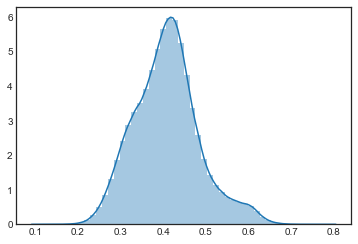

In [549]:
sns.distplot(x.flatten())

In [550]:
# t = -0.12
t = 0.5
xp = np.int32(x > t)
xps = np.sum(xp,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(31072,)
0 3.061598867147271 9


In [551]:
print(np.mean(xp,axis=0))

[0.6405 0.0756 0.2166 0.0862 0.0996 0.1561 0.0845 0.115  0.0019 0.0016 0.0013
 0.0883 0.0637 0.0354 0.0569 0.0008 0.0955 0.0224 0.0652 0.0904 0.0113 0.2516
 0.0804 0.1166 0.0285 0.5458 0.0283 0.0017]


In [552]:
# proportion of zero predictions
print(sum(xps==0)/x.shape[0])

0.00025746652935118434


In [553]:
f1_score(y, xp, average='macro')

0.5422115636124168

In [554]:
# make sure every image has at least one prediction
x1 = x.copy()
for i in range(x.shape[0]):
    x1[i,np.argmax(x[i])] = 30

In [555]:
t = 0.6
x1p = np.int32(x1 > t)
x1ps = np.sum(x1p,axis=1)
print(x1ps.shape)
print(x1ps.min(),x1ps.mean(),x1ps.max())

# proportion of zero predictions
print(sum(x1ps==0)/x1.shape[0])

f1_score(y, x1p, average='macro')

(31072,)
1 1.045796858908342 4
0.0


0.5954160791503844

In [556]:
# custom thresholds to match observed proportions
thresholds = np.linspace(1.0, 0.0, 1001)
pred = x.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (x[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= ymean[j]: break
    print(j,'%6.4f' % t,'%6.4f' % ymean[j],'%6.4f' % prop, LABEL_MAP[j])
print(f1_score(y, pred, average='macro'))

0 0.5460 0.4147 0.4178 Nucleoplasm
1 0.5620 0.0404 0.0404 Nuclear membrane
2 0.5350 0.1165 0.1174 Nucleoli
3 0.5400 0.0502 0.0504 Nucleoli fibrillar center
4 0.5470 0.0598 0.0602 Nuclear speckles
5 0.5340 0.0809 0.0813 Nuclear bodies
6 0.5540 0.0324 0.0329 Endoplasmic reticulum
7 0.5180 0.0908 0.0915 Golgi apparatus
8 0.5220 0.0017 0.0017 Peroxisomes
9 0.5110 0.0014 0.0014 Endosomes
10 0.5240 0.0009 0.0009 Lysosomes
11 0.5510 0.0352 0.0354 Intermediate filaments
12 0.5570 0.0221 0.0224 Actin filaments
13 0.5320 0.0173 0.0174 Focal adhesion sites
14 0.5700 0.0343 0.0343 Microtubules
15 0.5160 0.0007 0.0007 Microtubule ends
16 0.5600 0.0171 0.0171 Cytokinetic bridge
17 0.5620 0.0068 0.0069 Mitotic spindle
18 0.5320 0.0290 0.0292 Microtubule organizing center
19 0.5350 0.0477 0.0482 Centrosome
20 0.5370 0.0055 0.0056 Lipid droplets
21 0.5330 0.1216 0.1226 Plasma membrane
22 0.5560 0.0258 0.0262 Cell junctions
23 0.5170 0.0954 0.0957 Mitochondria
24 0.5760 0.0104 0.0104 Aggresome
25 0.5420

In [557]:
# estimate thresholds by least squares, from iafoss kernel
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.95*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params, maxfev=10000)
    return p

In [558]:
# #  pred = sigmoid_np(x)
# pred = x
# print(pred.min(),pred.mean(),pred.max())
# name_label_dict = LABEL_MAP
# th = fit_val(pred,y)
# # th[th<0.1] = 0.1
# print('Thresholds: ',th)
# print('F1 macro: ',f1_score(y, pred>th, average='macro'))
# # print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
# print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [559]:
pred = x
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val1(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

0.10639214398517906 0.4091124539781362 0.7902624378881279 28
Thresholds:  [0.5359 0.5717 0.5494 0.5437 0.5472 0.5475 0.5534 0.5304 0.5645 0.5363 0.5436
 0.5628 0.5563 0.5522 0.5632 0.6034 0.5712 0.5469 0.5294 0.531  0.5487 0.5257
 0.5565 0.5236 0.5811 0.5324 0.5456 0.5765]
F1 macro:  0.6730742099535624
F1 micro:  0.7178213072923662


In [560]:
# estimate thresholds by line search on observed proportions
def prop_mse(preds, targs, th=0.5):
    pm = np.mean((preds>th))
    tm = np.mean(targs)
#     print(th,pm,tm)
    return (tm - pm)**2
#     return (np.mean(targs) - np.mean((preds>th)))**2

def fit_val2(x, y, start=0.54):
    params = np.array([start])
    wd = 1e-5
#     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
    error = lambda p: np.array(prop_mse(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.,1.0], method='bounded').x
    p = opt.minimize_scalar(error, bounds=[0.4,0.6], method='bounded').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
    return p

In [561]:
# prop_mse(pred[:,0],y[:,0], 0.618)

In [562]:
# fit_val2(pred[:,0],y[:,0])

In [563]:
pred = x
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val2(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

0.10639214398517906 0.4091124539781362 0.7902624378881279 28
Thresholds:  [0.5466 0.5622 0.5359 0.5402 0.5479 0.5343 0.5545 0.5187 0.5234 0.5102 0.526
 0.5514 0.5577 0.5322 0.5702 0.5149 0.5603 0.5629 0.5322 0.5353 0.5378 0.5333
 0.557  0.5172 0.5764 0.5423 0.5541 0.5525]
F1 macro:  0.6558758178387615
F1 micro:  0.7141309912961284


In [564]:
np.mean(pred[:,0] > 0.618)

0.05490473738414006

In [565]:
# model- and class-specific thresholds 
# compute best threshold to maximize f1 score by grid search

thresholds = np.linspace(0, 1.0, 101)

fm = [[f1_score(y[:,j], (x[:,j] > t).astype(int)) \
       for t in thresholds] for j in range(y.shape[1])]

besti = [np.argmax(f) for f in fm]
bestt = [thresholds[b] for b in besti]
bests = [f[b] for f,b in zip(fm,besti)]

# td = {}
# print(special)
# for j in range(y.shape[1]):
#     # print(j, "%4.2f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
    
#     plt.plot(thresholds, fm[j])
#     plt.plot(bestt[j], bests[j], "xr", label="best")
#     plt.xlabel("threshold")
#     plt.ylabel("f1")
#     plt.title(LABEL_MAP[j] + " f1 vs threshold (%6.4f, %6.4f)" % (bestt[j], bests[j]))
#     plt.legend()
#     plt.show()
#     plt.gcf().clear()
 
print(special)
for j in range(y.shape[1]):
    print(j, "%5.3f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
    
print(np.mean(bests))   

resnet_u60
0 0.540 0.8129 Nucleoplasm
1 0.570 0.8161 Nuclear membrane
2 0.550 0.7754 Nucleoli
3 0.550 0.7364 Nucleoli fibrillar center
4 0.550 0.7548 Nuclear speckles
5 0.540 0.6778 Nuclear bodies
6 0.560 0.5236 Endoplasmic reticulum
7 0.530 0.7866 Golgi apparatus
8 0.510 0.8704 Peroxisomes
9 0.540 0.8395 Endosomes
10 0.540 0.8846 Lysosomes
11 0.570 0.7245 Intermediate filaments
12 0.560 0.6080 Actin filaments
13 0.550 0.5989 Focal adhesion sites
14 0.570 0.8429 Microtubules
15 0.610 0.6667 Microtubule ends
16 0.570 0.4155 Cytokinetic bridge
17 0.570 0.3715 Mitotic spindle
18 0.530 0.5121 Microtubule organizing center
19 0.530 0.6277 Centrosome
20 0.550 0.5437 Lipid droplets
21 0.530 0.5869 Plasma membrane
22 0.560 0.5595 Cell junctions
23 0.520 0.7763 Mitochondria
24 0.580 0.6741 Aggresome
25 0.530 0.6643 Cytosol
26 0.580 0.4280 Cytoplasmic bodies
27 0.580 0.7619 Rods & rings
0.6728786772301338


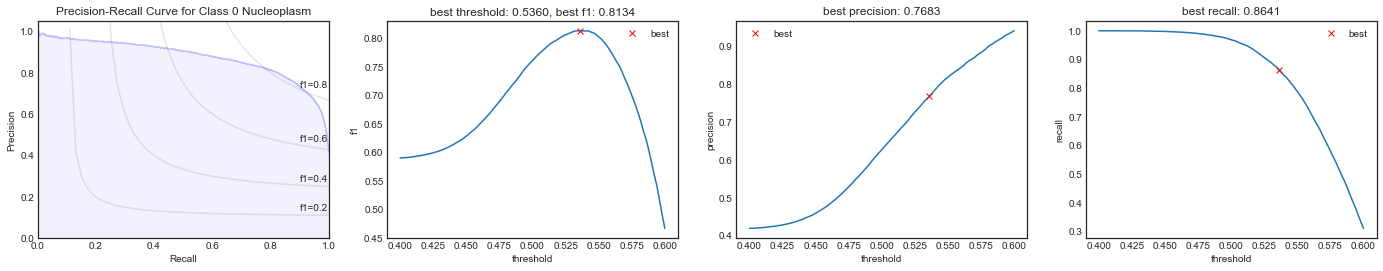

<Figure size 432x288 with 0 Axes>

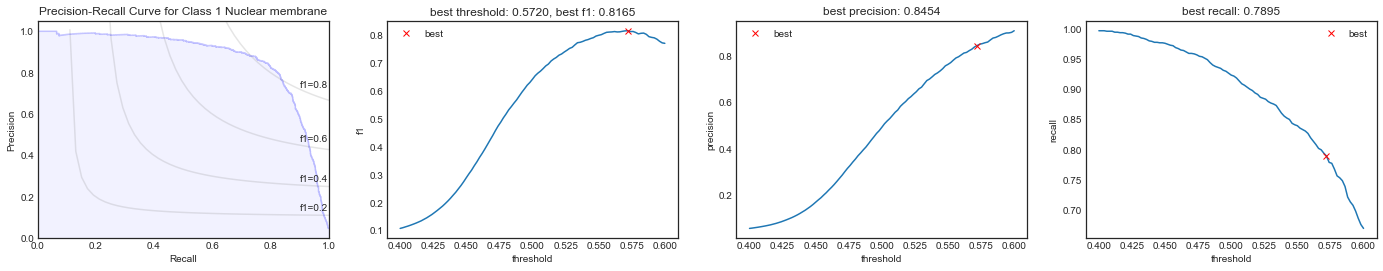

<Figure size 432x288 with 0 Axes>

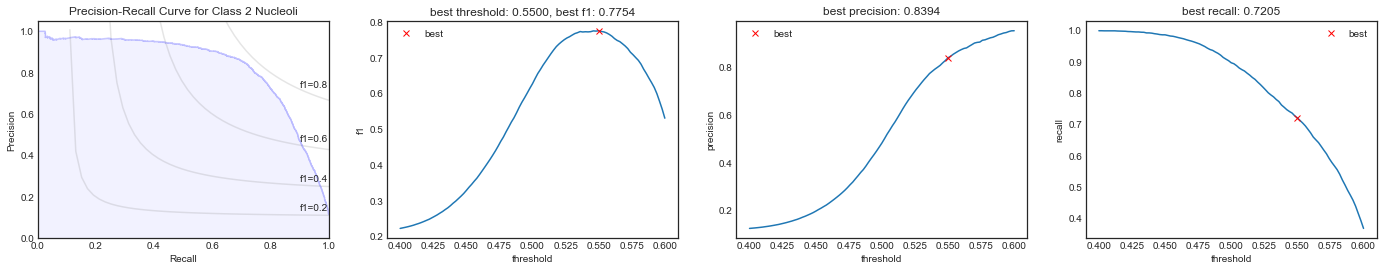

<Figure size 432x288 with 0 Axes>

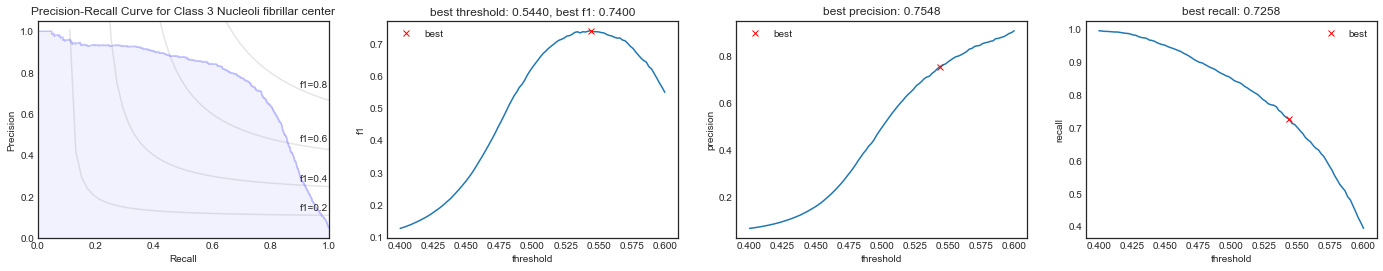

<Figure size 432x288 with 0 Axes>

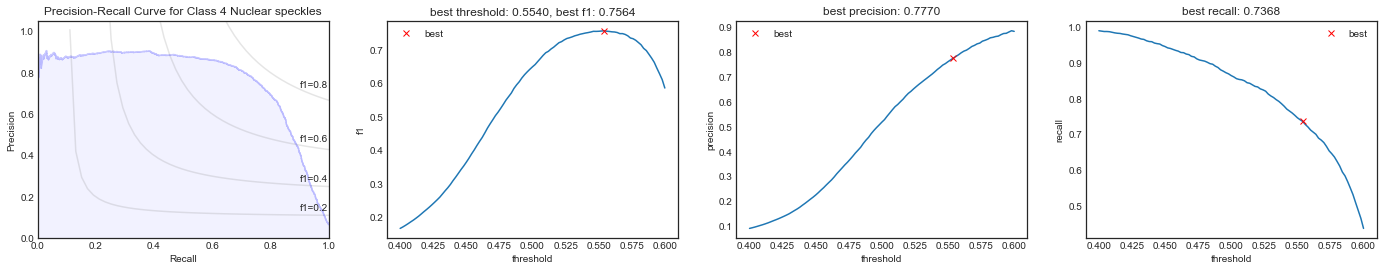

<Figure size 432x288 with 0 Axes>

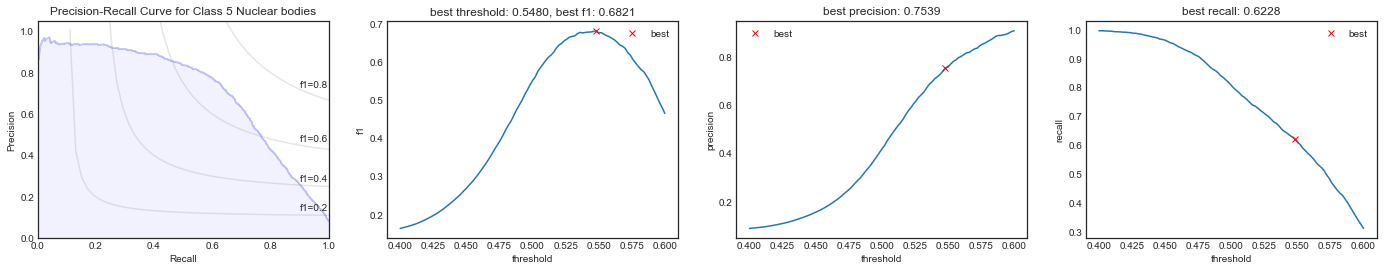

<Figure size 432x288 with 0 Axes>

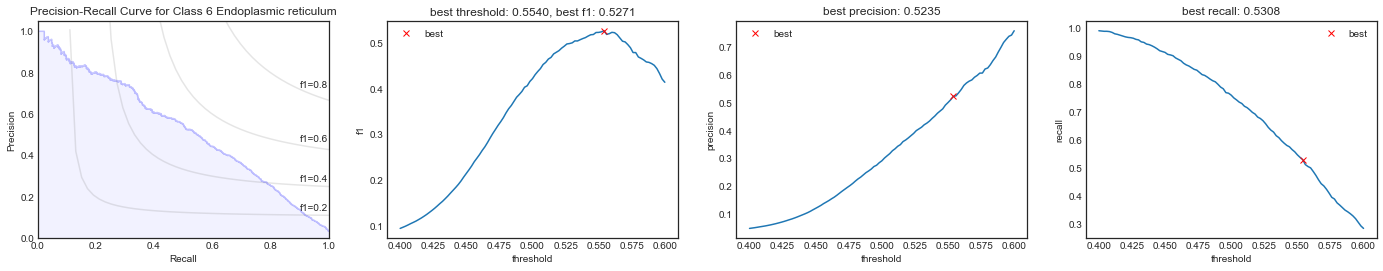

<Figure size 432x288 with 0 Axes>

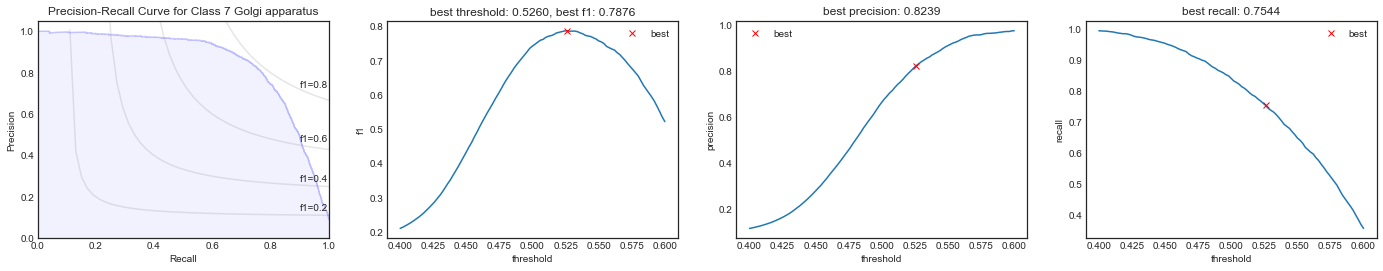

<Figure size 432x288 with 0 Axes>

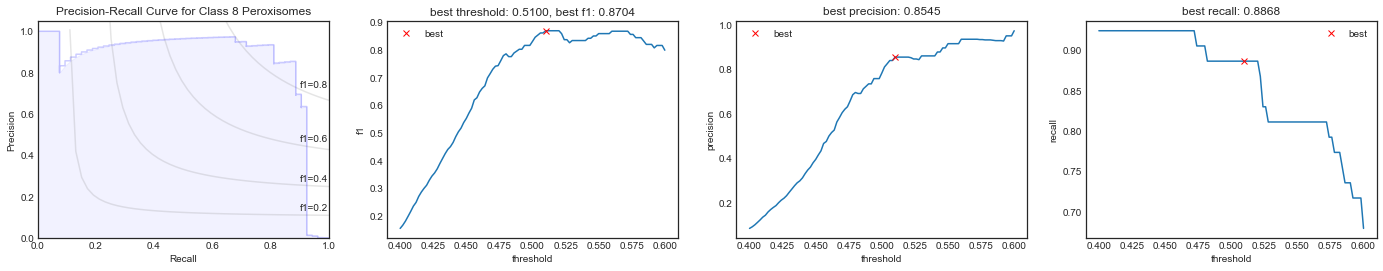

<Figure size 432x288 with 0 Axes>

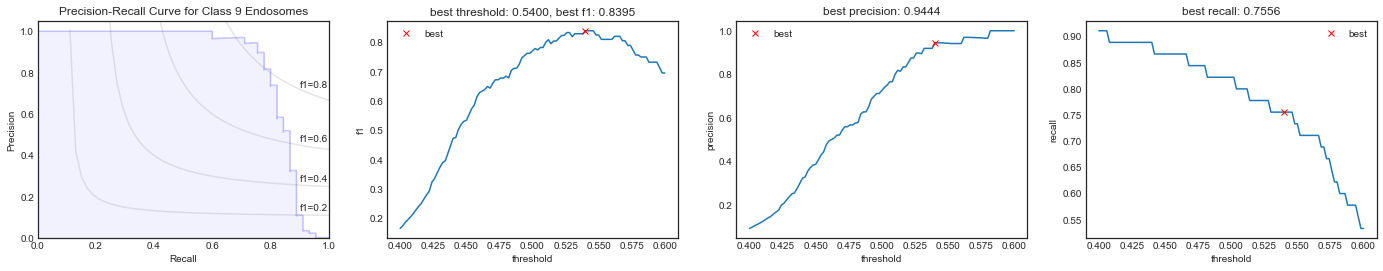

<Figure size 432x288 with 0 Axes>

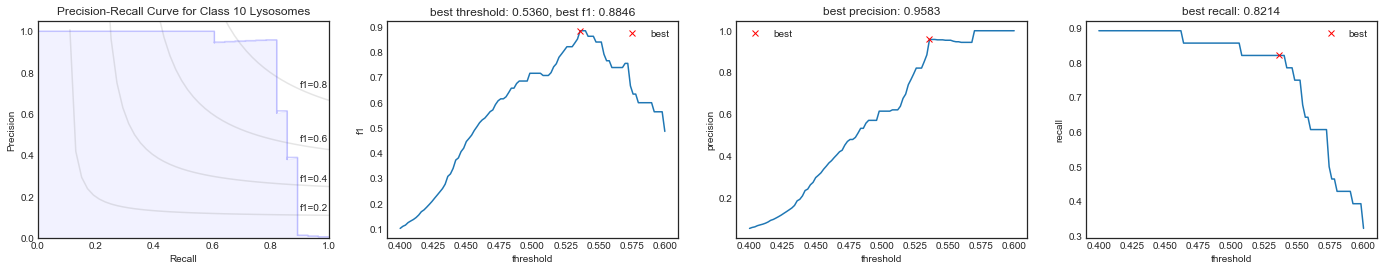

<Figure size 432x288 with 0 Axes>

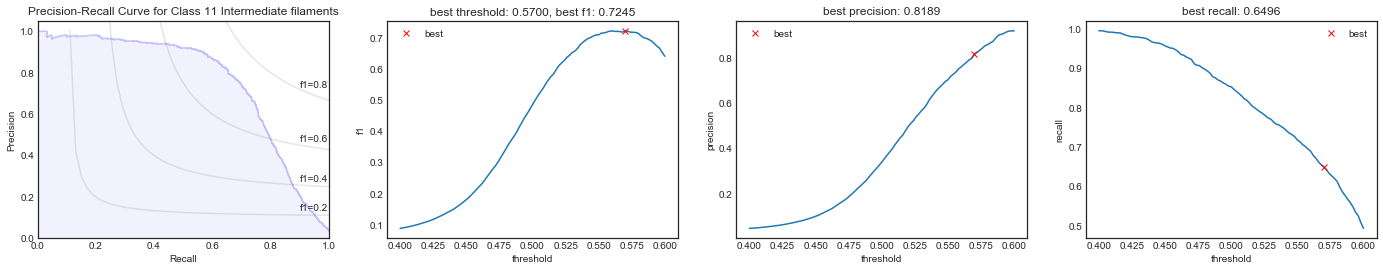

<Figure size 432x288 with 0 Axes>

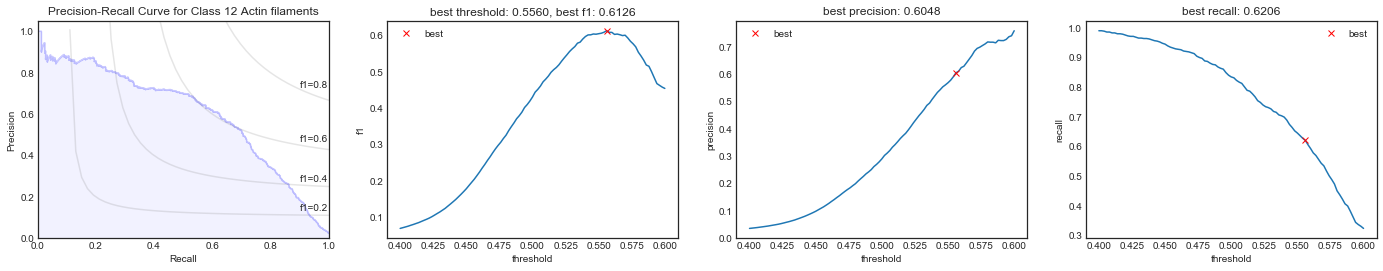

<Figure size 432x288 with 0 Axes>

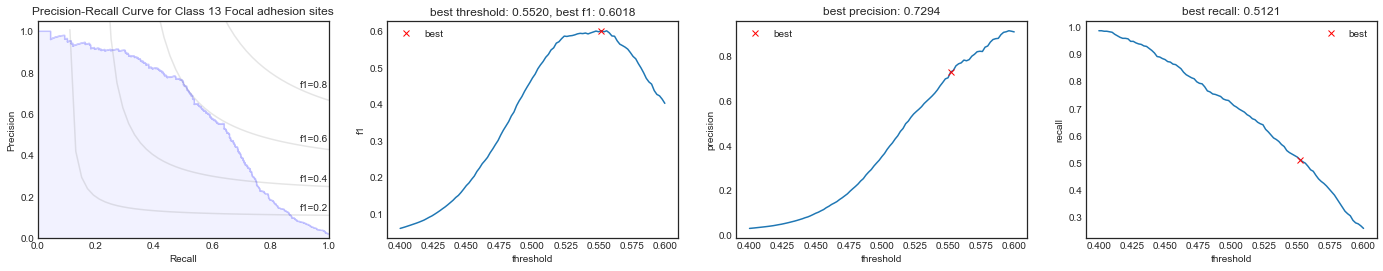

<Figure size 432x288 with 0 Axes>

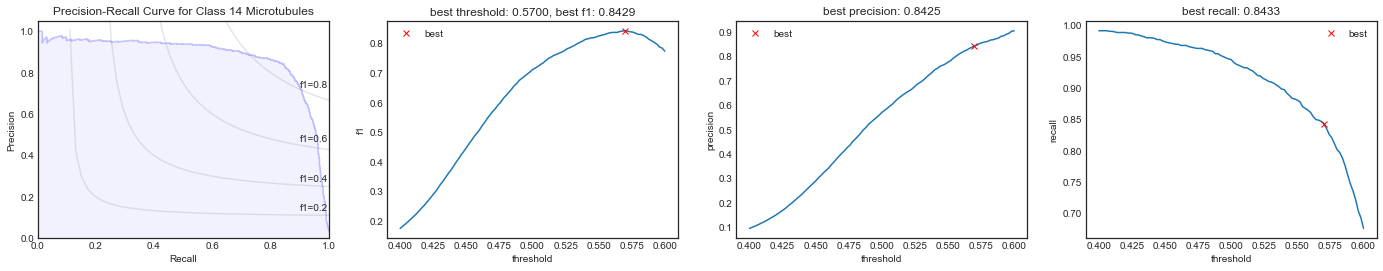

<Figure size 432x288 with 0 Axes>

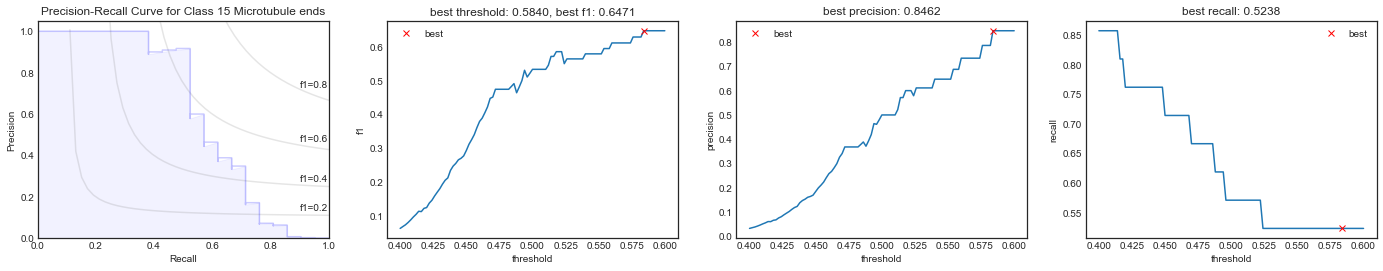

<Figure size 432x288 with 0 Axes>

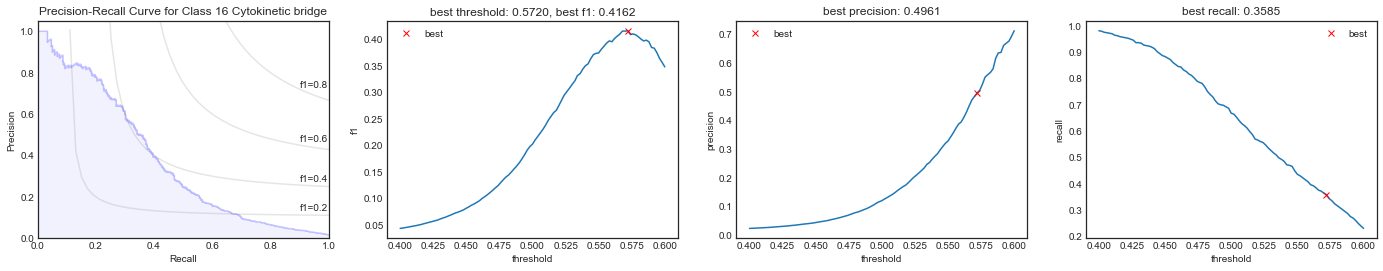

<Figure size 432x288 with 0 Axes>

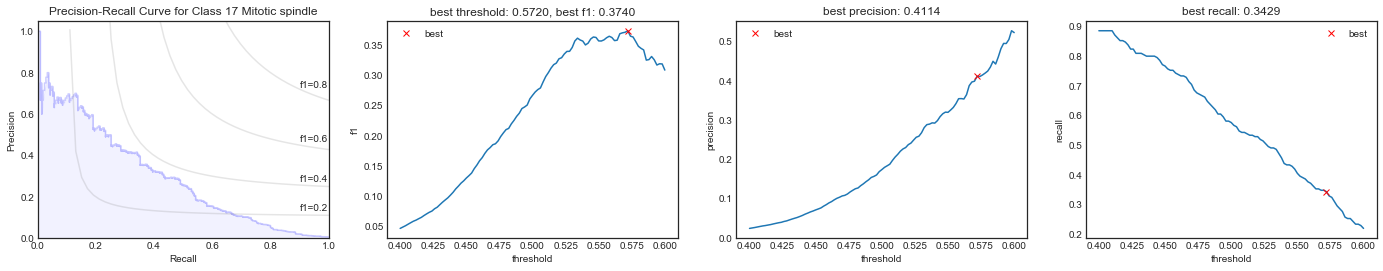

<Figure size 432x288 with 0 Axes>

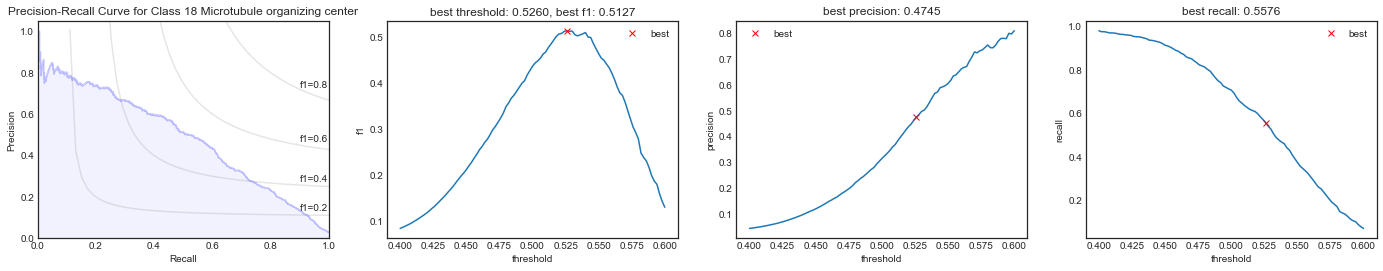

<Figure size 432x288 with 0 Axes>

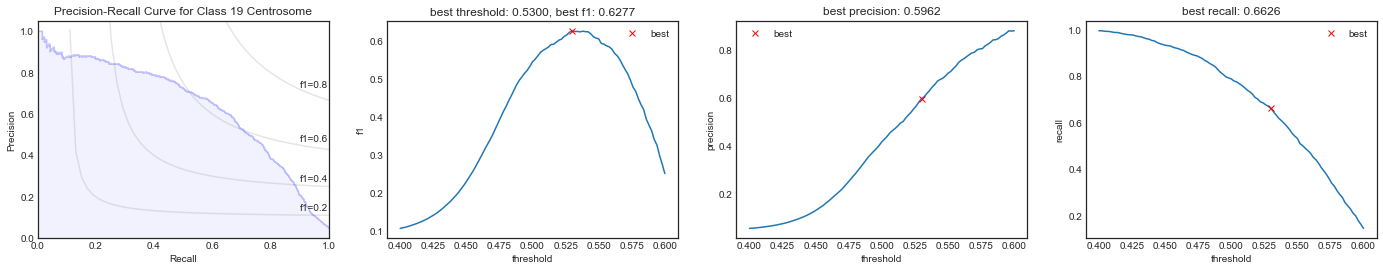

<Figure size 432x288 with 0 Axes>

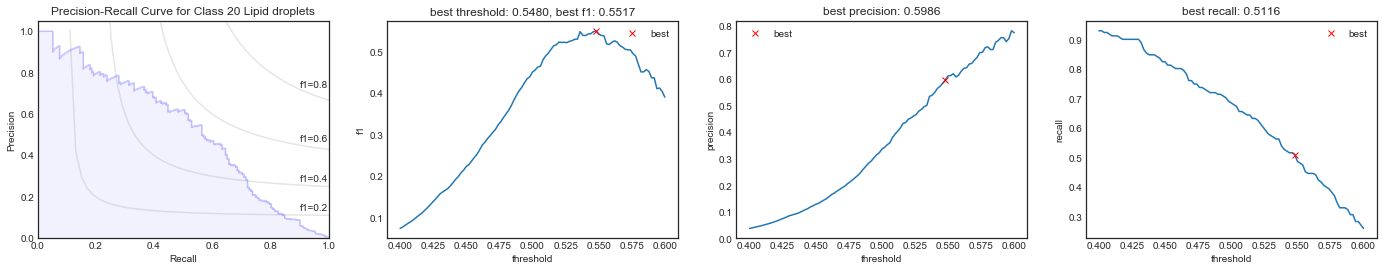

<Figure size 432x288 with 0 Axes>

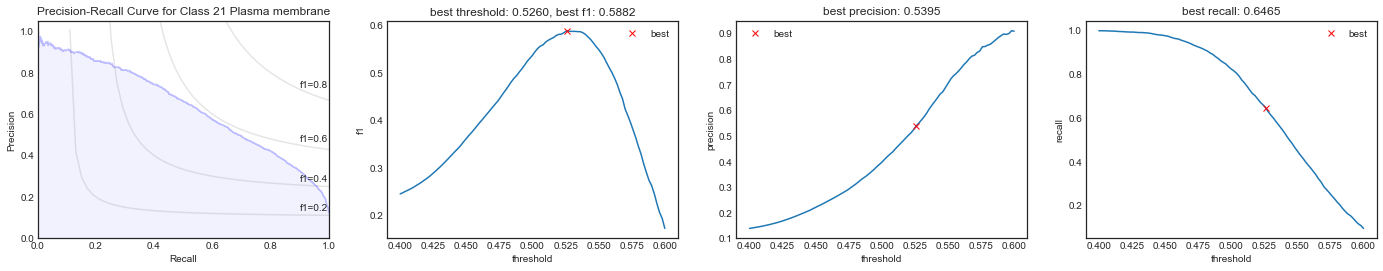

<Figure size 432x288 with 0 Axes>

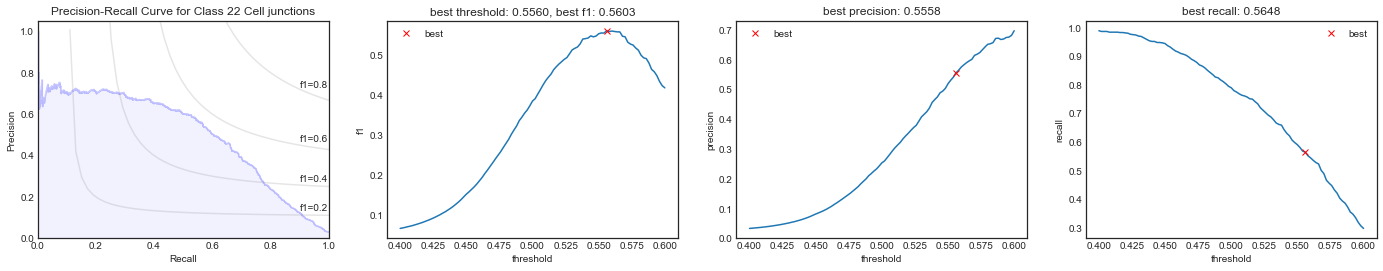

<Figure size 432x288 with 0 Axes>

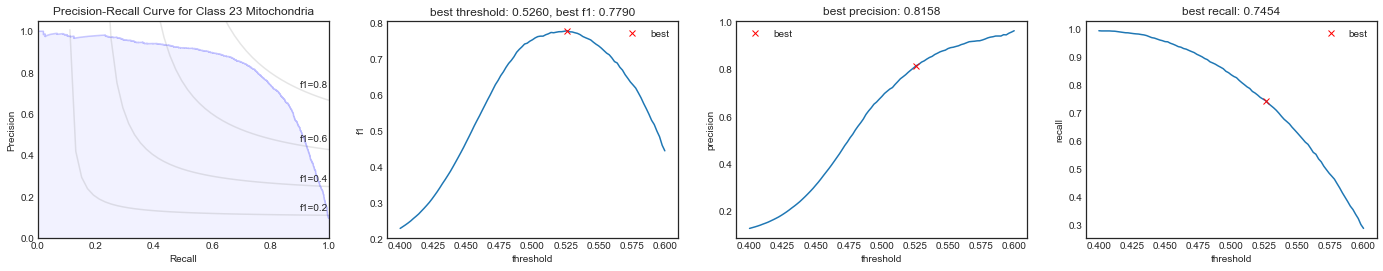

<Figure size 432x288 with 0 Axes>

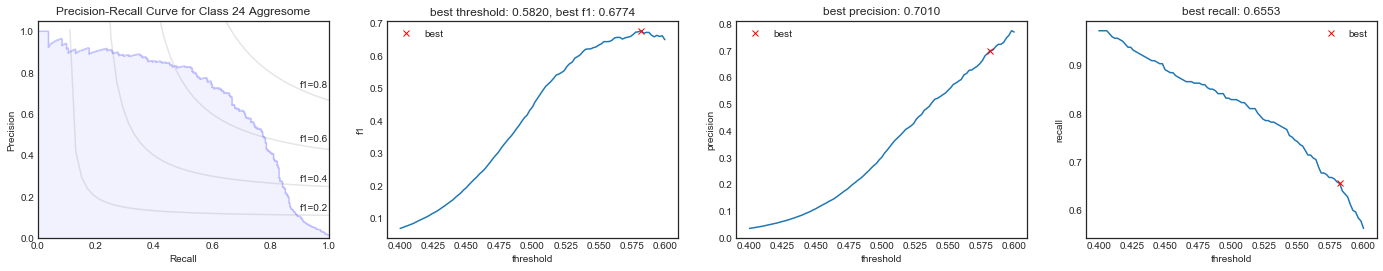

<Figure size 432x288 with 0 Axes>

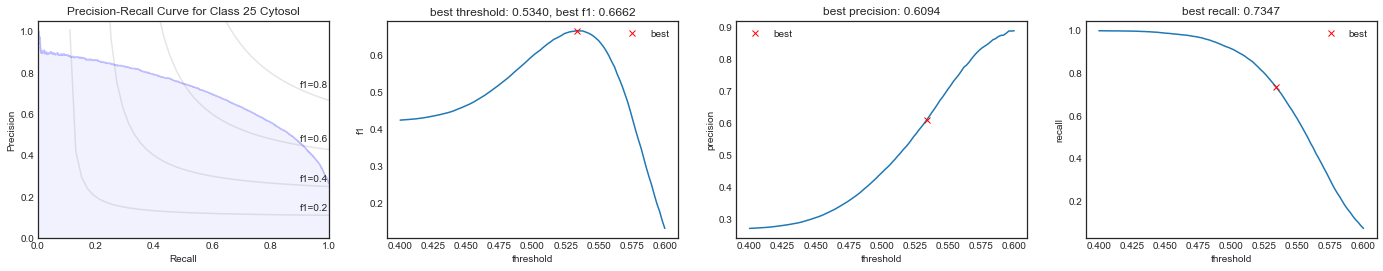

<Figure size 432x288 with 0 Axes>

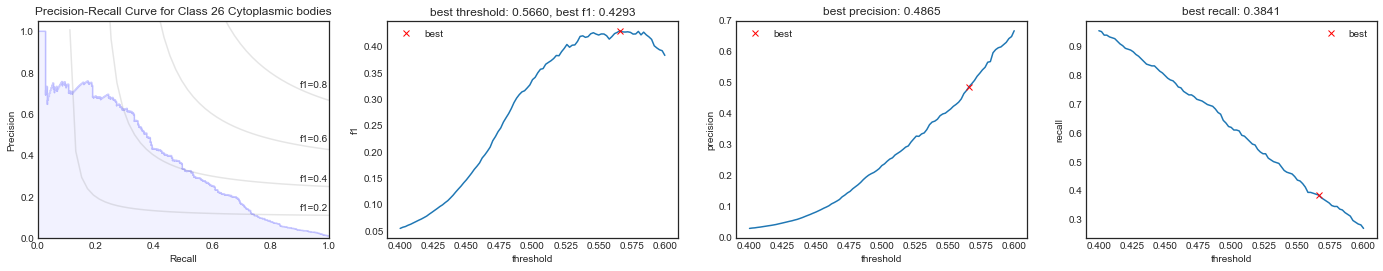

<Figure size 432x288 with 0 Axes>

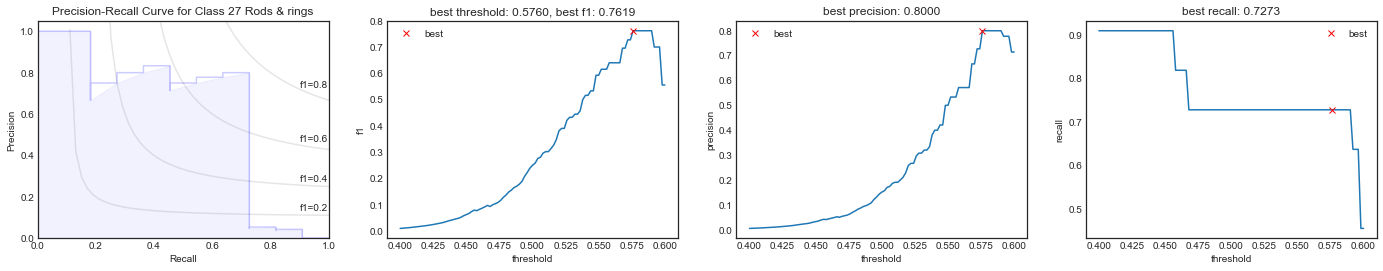

<Figure size 432x288 with 0 Axes>

In [566]:
n_classes = 28

# plot precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
f_scores = np.linspace(0.2, 0.8, num=4)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i], x[:, i])
    average_precision[i] = average_precision_score(y[:, i], x[:, i])
    
#     plt.figure()
    
#     for f_score in f_scores:
#         xf = np.linspace(0.01, 1)
#         yf = f_score * xf / (2 * xf - f_score)
#         l, = plt.plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

#     plt.step(recall[i], precision[i], color='b', alpha=0.2, where='post')
#     plt.fill_between(recall[i], precision[i], alpha=0.05, color='b')

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title(LABEL_MAP[i])
    
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 4))
    
    for f_score in f_scores:
        xf = np.linspace(0.01, 1)
        yf = f_score * xf / (2 * xf - f_score)
        l, = axs[0].plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
        axs[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

    axs[0].step(recall[i], precision[i], color='b', alpha=0.2, where='post')
    axs[0].fill_between(recall[i], precision[i], alpha=0.05, color='b')

    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_title('Precision-Recall Curve for Class ' + str(i) + ' ' + LABEL_MAP[i])
    
    
    thresholds = np.linspace(0.4, 0.6, 101)
    # for ranks
    # thresholds = np.linspace(0.8, 1.0, 101)
    fm = [f1_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 

    besti = np.argmax(fm)
    bestt = thresholds[besti]
    bests = fm[besti] 
        
    axs[1].plot(thresholds, fm)
    axs[1].plot(bestt, bests, "xr", label="best")
    axs[1].set_xlabel("threshold")
    axs[1].set_ylabel("f1")
    axs[1].set_title("best threshold: %6.4f, best f1: %6.4f" % (bestt, bests))
    axs[1].legend()

    pm = [precision_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 
    bestsp = pm[besti] 
        
    axs[2].plot(thresholds, pm)
    axs[2].plot(bestt, bestsp, "xr", label="best")
    axs[2].set_xlabel("threshold")
    axs[2].set_ylabel("precision")
    axs[2].set_title("best precision: %6.4f" % (bestsp))
    axs[2].legend()
    
    rm = [recall_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 
    bestsr = rm[besti] 
        
    axs[3].plot(thresholds, rm)
    axs[3].plot(bestt, bestsr, "xr", label="best")
    axs[3].set_xlabel("threshold")
    axs[3].set_ylabel("recall")
    axs[3].set_title("best recall: %6.4f" % (bestsr))
    axs[3].legend()
    
    plt.show()
    plt.gcf().clear()

In [567]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(), x.ravel())

average_precision["macro"] = average_precision_score(y, x, average="macro")
print('Average precision score, macro-averaged over all classes: {0:0.3f}'
      .format(average_precision["macro"]))

average_precision["micro"] = average_precision_score(y, x, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.3f}'
      .format(average_precision["micro"]))


Average precision score, macro-averaged over all classes: 0.676
Average precision score, micro-averaged over all classes: 0.756


In [568]:
# for i in range(len(th)):
#     print(i,np.round(th[i],decimals=2))

In [569]:
# print(np.mean(x > th,axis=0))

In [570]:
# f1_score(y, xp, average='samples')

In [571]:
f1_score(y, xp, average='micro')

0.6119715993201381

In [572]:
z = [(y,x) for y,x in zip(y,xp) if np.sum(x) == 0]
print(len(z))

8


In [573]:
# z[:5]

In [574]:
yz = np.array([t[0] for t in z])
xz = np.array([t[1] for t in z])
f1_score(yz,xz,average='macro')

0.0

0.0 0.631506296226945 1.0


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


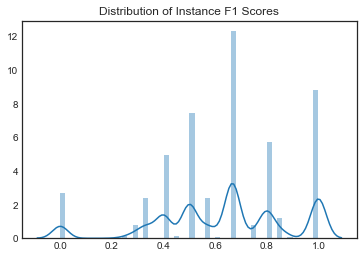

<Figure size 432x288 with 0 Axes>

In [575]:
f1b = np.array([f1_score(yi, xpi, average='binary') \
                 for yi,xpi in zip(y,xp)])
print(f1b.min(),f1b.mean(),f1b.max())
sns.distplot(f1b)
plt.title("Distribution of Instance F1 Scores")
plt.show()
plt.gcf().clear()

In [576]:
np.set_printoptions(precision=3, linewidth=200, suppress=True)
f = []
for m in mnames:
    ff = np.array(list(vp[m])).flatten()
    print(m, ff.shape)
    f.append(ff)
# print(mnames)
r = np.corrcoef(f)
print(r)   

iv3_q11 (870016,)
irv2_q10 (870016,)
resnet_q24 (870016,)
resnet_q25 (870016,)
resnet_q40 (870016,)
gap_q12 (870016,)
nas_q11 (870016,)
se_resnext_q26 (870016,)
se_resnext_q28 (870016,)
bni_q0 (870016,)
bni_q1 (870016,)
iv3_q12 (870016,)
iv3_u11 (870016,)
iv3_u12 (870016,)
resnet_q26 (870016,)
resnet_q27 (870016,)
resnet_u25 (870016,)
resnet_u31 (870016,)
resnet_u56 (870016,)
resnet_u60 (870016,)
resnet_u101 (870016,)
gap_u14 (870016,)
bni_u1 (870016,)
bni_u2 (870016,)
[[1.    0.878 0.899 0.902 0.886 0.876 0.838 0.859 0.818 0.888 0.891 0.967 0.867 0.812 0.863 0.873 0.879 0.852 0.833 0.821 0.842 0.872 0.886 0.829]
 [0.878 1.    0.896 0.897 0.881 0.871 0.844 0.857 0.813 0.896 0.891 0.854 0.873 0.799 0.856 0.871 0.88  0.859 0.826 0.817 0.834 0.866 0.887 0.812]
 [0.899 0.896 1.    0.951 0.948 0.928 0.873 0.882 0.828 0.928 0.922 0.876 0.884 0.799 0.916 0.916 0.926 0.891 0.831 0.822 0.845 0.883 0.92  0.823]
 [0.902 0.897 0.951 1.    0.944 0.922 0.87  0.883 0.836 0.932 0.934 0.878 0.888 0.811

In [577]:
loc = [i for i,m in enumerate(mnames) if m == special][0]
rloc = r[:,loc]
print(rloc)
order = np.argsort(rloc)
for i in range(1,min(len(rloc)+1,7)):
    print('%5.3f' % rloc[order[-i]],mnames[order[-i]])

[0.821 0.817 0.822 0.831 0.813 0.796 0.779 0.801 0.782 0.839 0.836 0.808 0.813 0.835 0.799 0.818 0.831 0.864 0.867 1.    0.868 0.849 0.84  0.848]
1.000 resnet_u60
0.868 resnet_u101
0.867 resnet_u56
0.864 resnet_u31
0.849 gap_u14
0.848 bni_u2


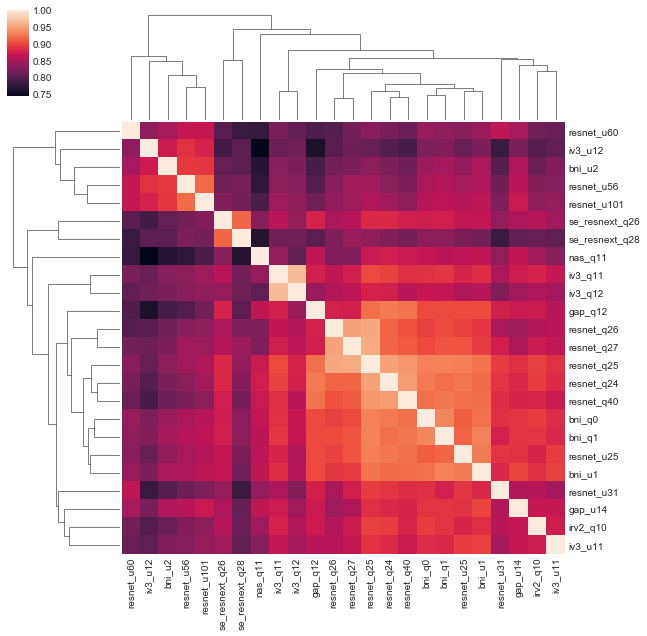

In [578]:
d = pd.DataFrame(r, columns=mnames)
d['id'] = mnames
d.set_index('id',inplace=True)
del d.index.name

sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [579]:
# f = []
# for m in mnames:
#     f.append(np.array(list(vp[m])).flatten())
# print(mnames)
# print(np.corrcoef(f))   

In [580]:
print(f[0].min(),f[0].max())

0.003531752538329119 0.873710232392001


In [581]:
# # model-specific global thresholds
# # compute best single logit threshold for computed ensemble

# # for probabilities
# thresholds = np.linspace(0.1, 0.9, 1001)

# # for logits
# # thresholds = np.linspace(-1, 1, 101)

# # for ranks
# # thresholds = np.linspace(0.9, 1, 101)

# # thresholds = [-0.4]

# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# else: mthresh = {}
# # mthresh = {}

# for i in range(nm):
# # for i in [3]:

#     mname = vp.columns[i+offset]

#     tv = np.array(list(vp.iloc[:,offset+i].values))
    
#     if mname in mthresh or np.sum(np.isnan(tv)) > 0: continue

#     scores = np.array([f1_score(y, np.int32(tv > threshold),
#                                  average='macro') for threshold in thresholds])

#     besta = np.argmax(scores)
#     threshold_best = thresholds[besta]
#     score_best = scores[besta]
#     print(i, mname, "%4.2f" % threshold_best, "%6.4f" % score_best)
#     mthresh[mname] = threshold_best
    
#     plt.plot(thresholds, scores)
#     plt.plot(threshold_best, score_best, "xr", label="best")
#     plt.xlabel("threshold")
#     plt.ylabel("f1")
# #     plt.title(mname + " f1 vs threshold (%6.4f, %6.4f)" % (threshold_best, score_best))
#     plt.title(mname + " threshold: %6.4f  f1: %6.4f" % (threshold_best, score_best))
#     plt.legend()
#     plt.show()
#     plt.gcf().clear()

# pickle.dump(mthresh,open(fname,'wb'))
# print(mthresh)

In [582]:
vp.columns

Index(['Target', 'y', 'iv3_q11', 'irv2_q10', 'resnet_q24', 'resnet_q25',
       'resnet_q40', 'gap_q12', 'nas_q11', 'se_resnext_q26', 'se_resnext_q28',
       'bni_q0', 'bni_q1', 'iv3_q12', 'iv3_u11', 'iv3_u12', 'resnet_q26',
       'resnet_q27', 'resnet_u25', 'resnet_u31', 'resnet_u56', 'resnet_u60',
       'resnet_u101', 'gap_u14', 'bni_u1', 'bni_u2'],
      dtype='object')

In [583]:
# # model- and class-specific thresholds
# # compute best logit threshold for computed ensemble

# # thresholds = np.linspace(-2, 2, 101)

# # thresholds = [-0.4]

# fname = 'cthresh.pkl'
# # if os.path.isfile(fname): cthresh = pickle.load(open(fname,'rb'))
# cthresh = {}

# for i in range(nm):
# # for i in [2]:

#     mname = vp.columns[i+offset]
#     tv = np.array(list(vp.iloc[:,offset+i].values))

#     fm = [[f1_score(y[:,j], (tv[:,j] > t).astype(int)) \
#            for t in thresholds] for j in range(y.shape[1])]
    
#     besti = [np.argmax(f) for f in fm]
#     bestt = [thresholds[b] for b in besti]
#     bests = [f[b] for f,b in zip(fm,besti)]
#     print(mname, np.mean(bests))
    
#     td = {}
#     for j in range(y.shape[1]):
#         # print()
#         # print(j, LABEL_MAP[j], "%4.2f" % bestt[j], "%6.4f" % bests[j])
        
#         # print(j, "%4.2f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
        
#         # print(cm[j], '%4.2f' % fm[j])
#         # print('')
#         td[j] = np.round(bestt[j],decimals=2)
    
#     cthresh[mname] = td
#     print()
    
# pickle.dump(cthresh,open(fname,'wb'))
# # print(cthresh)
# print(fname)

optimizing f1 by hillcliming
model 0 f1 for iv3_q11 = 0.6371
model 1 f1 for irv2_q10 = 0.6203
model 2 f1 for resnet_q24 = 0.6337
model 3 f1 for resnet_q25 = 0.6278
model 4 f1 for resnet_q40 = 0.6229
model 5 f1 for gap_q12 = 0.6127
model 6 f1 for nas_q11 = 0.5267
model 7 f1 for se_resnext_q26 = 0.5831
model 8 f1 for se_resnext_q28 = 0.6187
model 9 f1 for bni_q0 = 0.6300
model 10 f1 for bni_q1 = 0.6180
model 11 f1 for iv3_q12 = 0.6473
model 12 f1 for iv3_u11 = 0.6555
model 13 f1 for iv3_u12 = 0.6840
model 14 f1 for resnet_q26 = 0.6268
model 15 f1 for resnet_q27 = 0.6554
model 16 f1 for resnet_u25 = 0.6527
model 17 f1 for resnet_u31 = 0.6539
model 18 f1 for resnet_u56 = 0.6895
model 19 f1 for resnet_u60 = 0.6731
model 20 f1 for resnet_u101 = 0.6812
model 21 f1 for gap_u14 = 0.6253
model 22 f1 for bni_u1 = 0.6468
model 23 f1 for bni_u2 = 0.6600
step = 0   index = 18   name = resnet_u56    f1 = 0.6895
    try 0 iv3_q11 0.6973
    try 1 irv2_q10 0.6950
    try 2 resnet_q24 0.6993
    try 3 r

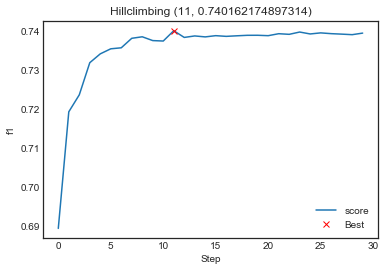

    step  midx     score          mod      f1_0
0      0    18  0.689526   resnet_u56  0.689526
1      1    17  0.719396   resnet_u31  0.653915
2      2    15  0.723744   resnet_q27  0.655447
3      3    13  0.731977      iv3_u12  0.684011
4      4    19  0.734243   resnet_u60  0.673074
5      5    11  0.735535      iv3_q12  0.647281
6      6    17  0.735794   resnet_u31  0.653915
7      7    13  0.738228      iv3_u12  0.684011
8      8    17  0.738614   resnet_u31  0.653915
9      9    20  0.737642  resnet_u101  0.681225
10    10    14  0.737526   resnet_q26  0.626805
11    11    19  0.740162   resnet_u60  0.673074

      weight          mod      f1_0
midx                               
11         1      iv3_q12  0.647281
13         2      iv3_u12  0.684011
14         1   resnet_q26  0.626805
15         1   resnet_q27  0.655447
17         3   resnet_u31  0.653915
18         1   resnet_u56  0.689526
19         2   resnet_u60  0.673074
20         1  resnet_u101  0.681225


<Figure size 432x288 with 0 Axes>

In [584]:
# oof = small

# hillclimbing
# vp = oof.copy()
# offset = 5
# nm = vp.shape[1] - offset
nr = vp.shape[0]
y = np.array([y for y in vp.y])
# y = np.array(list(vp['masks'].values))
nstep = 30

step0fix = -1
# step0fix = 5
step1fix = -1

intercept = 0
rez = pd.DataFrame({'step':np.zeros(nstep).astype(int),'midx':np.zeros(nstep).astype(int),
                    'score':np.zeros(nstep)})
currEnsemble = 0 * np.array(list(vp.iloc[:,offset].values))

metric = 'f1'
# metric = 'iou'

# threshold = 0.
# threshold = 0.36
threshold = 0.49
# threshold = 0.5
# print('using ' + metric + ' threshold',threshold)
print('optimizing ' + metric + ' by hillcliming')


# metric = "mcc"
# metric = "corr"
# metric = "rmse"
# metric = "mse"
# metric = "mae"
# metric = "winsorized_mae"
# metric = "auc"

cut_mets = ['mcc']

num_classes = 28
th = np.zeros(num_classes)
threshold_best = threshold

# maximizing
bestScore = -9999999
single = pd.DataFrame({'mod':np.repeat("",nm)})
start = 0
for step in range(start,nstep):
    single[metric+'_'+str(step)] = np.nan

for step in range(start,nstep):
    currIndex = 0
    currScore = -9999999

    for i in range(nm):

        mname = vp.columns[i+offset]
        
        tv = np.array(list(vp.iloc[:,offset+i].values))

        # mean-center
#         tv = tv - np.mean(tv)

        # adjust by model-specific threshold
#         tv = tv - mthresh[mname]
        
        # adjust by model-class-specific thresholds
#         for j in range(tv.shape[1]):
#             tv[:,j] = tv[:,j] - cthresh[mname][j]

        if np.sum(np.isnan(tv)) > 0: continue
            
        if step==0:
            tryEnsemble = tv
        else:
            # running mean
            tryEnsemble = (step * currEnsemble + tv)/(step+1)
            # full matrix
            # choose median or mean here
            # tryEnsemble = rowMedians(cbind(currEnsemble,tv))
            # tryEnsemble = rowMeans(cbind(currEnsemble,tv))
            # quantiles are a lot slower
            # tryEnsemble = rowQuantiles(cbind(currEnsemble,tv),probs=0.6)

        if metric=="f1":
#             # estimate new class-specific thresholds by least squares, very slow
#             th = fit_val(tryEnsemble,y)
#             th[th<0.1] = 0.1
#             tryScore = f1_score(y, np.int32(tryEnsemble > th),
#                                 average='macro')

            # estimate new class-specific thresholds by line search, slow
            for j in range(num_classes):
                th[j] = fit_val1(tryEnsemble[:,j],y[:,j])
            tryScore = f1_score(y, np.int32(tryEnsemble > th),
                                average='macro')
            
#             # estimate new class-specific thresholds to match proportions, medium
#             for j in range(num_classes):
#                 th[j] = fit_val2(tryEnsemble[:,j],y[:,j])
#             tryScore = f1_score(y, np.int32(tryEnsemble > th),
#                                 average='macro')

#             # fixed threshold, fast
#             tryScore = f1_score(y, np.int32(tryEnsemble > threshold),
#                                 average='macro')

            if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
        elif metric=="iou":
            tryScore = iou_metric_batch(y, np.int32(tryEnsemble > threshold),
                                        pred_eps=pred_eps)
            if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
        elif metric=="mse":
            tryScore = -mse(y,tryEnsemble)
        elif metric=="mae": 
            tryScore = -mae(y,tryEnsemble)
        elif metric=="winsorized_mae": 
            tryScore = -winsorized_mae(y,tryEnsemble+intercept)
        elif metric=="rmse":
            tryScore = -rmse(y,tryEnsemble)
        elif metric=="corr":
            tryScore = cor(y,tryEnsemble)
        elif metric=="mcc":
            opt = eval_mcc3(y,tryEnsemble,cut=T)
            tryScore = opt[1]
            cut = opt[2]
            # opt = optimize(mcc,c(0.1,0.3),tryEnsemble,vp$y,maximum=T)
            # tryScore = opt$objective
        elif metric=="logloss":
            # tryScore = -logLoss(vp$y,tryEnsemble,)
            tryScore = -eval_logloss2(tryEnsemble,y)
        elif metric=="auc":
            tryScore = auc2(y,tryEnsemble)
        elif metric=="auprc":
            tryScore = auprc(tryEnsemble, y)
            # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
            # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.davis.goadrich
        elif metric=="aurocpr":
            auroc = auc(y,tryEnsemble)
            # auprc = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
            tryScore = (auroc + auprc)/2
        elif metric=="sqwk":
            tryScore = sqwk(y,tryEnsemble,1,8)
        
        ok = 1
        if (step==0) and (step0fix>-1) and (i!=step0fix): ok = 0 
        if (step==1) and (step1fix>-1) and (i!=step1fix): ok = 0 

        if (tryScore > currScore) and (ok==1):
            currIndex = i
            currScore = tryScore
            if (step==0):
                saveEnsemble = tv.copy()
            else:
                # running mean
                saveEnsemble = tryEnsemble.copy()
                # save whole matrix
                # saveEnsemble = np.concatenate((currEnsemble,tv),axis=1)
            if metric in cut_mets: currCut = cut

        # if (step==0) or ((step==1) and (step0fix>-1)) or ((step==2) and (step1fix>-1)):
        if (step==0):
            if (metric=="mcc"):
                print("model",i,metric,"for",vp.columns[i+offset],"=",tryScore,"  cut =",cut,"\n")
            else:
                print("model",i,metric,"for",vp.columns[i+offset],"= %6.4f" % tryScore)

        if step==0:
            single.loc[i,'mod'] = vp.columns[i+offset]  
        single.iloc[i,step+1] = tryScore

    if metric=="mcc":
        print("step =",step,"  index =",currIndex,"  name =", vp.columns[currIndex+offset],"  ",
            metric,"= %6.4f" % currScore,"  cut =",currCut)
    else:
        print("step =",step,"  index =",currIndex,"  name =", vp.columns[currIndex+offset],"  ",
            metric,"= %6.4f" % currScore)

    currEnsemble = saveEnsemble.copy()
    if currScore > bestScore:
        bestScore = currScore
        bestStep = step
        bestEnsemble = currEnsemble.copy()
        if metric in cut_mets: bestCut = currCut

    rez.iloc[step,0] = step
    rez.iloc[step,1] = currIndex
    rez.iloc[step,2] = currScore

if (metric=="mcc"):
    print("best step =",bestStep,"  best",metric,"=",bestScore,"  best cut =",bestCut)
else:
    print("best step =",bestStep,"  best",metric,"=",bestScore)

rez0 = rez.copy()

# tb = table(rez$index[1:bestStep])
# names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

# if (intercept!=0) {
#   tb["Intercept"] = intercept
# }

# print(tb[order(-tb)])
# print(single[order(-single[,2]),][1:min(nrow(single),40),])

# plot hillclimbing
print('')
plt.plot(rez0.step, rez0.score)
plt.plot(bestStep, bestScore, "xr", label="Best")
plt.xlabel("Step")
plt.ylabel(metric)
plt.title("Hillclimbing ({}, {})".format(bestStep, bestScore))
plt.legend()
plt.show()
plt.gcf().clear()

# display the weights
rez = rez.iloc[:(bestStep+1)]
# print(rez)

single0 = single.iloc[:,:2]

rez['midx'] = rez['midx'].astype(int)
rez = rez.join(single0,how='left',on='midx')
print(rez)
print('')

rez['weight'] = 1
tb = rez.loc[:,['midx','weight']].groupby('midx').count()
# print(tb)
# print(single)

tb = tb.join(single0,how='left')
print(tb)

bestEnsemble0 = bestEnsemble.copy()

In [585]:
pred = bestEnsemble0
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val1(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

0.1318764449093568 0.3902008607127413 0.6799056389963277 28
Thresholds:  [0.532 0.539 0.527 0.523 0.533 0.523 0.536 0.519 0.475 0.489 0.498 0.521 0.538 0.528 0.545 0.46  0.533 0.521 0.52  0.519 0.509 0.522 0.536 0.523 0.517 0.523 0.516 0.5  ]
F1 macro:  0.740162174897314
F1 micro:  0.7612684907667022


In [586]:
pred = bestEnsemble0
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th1 = np.zeros(num_classes)
for i in range(num_classes):
    th1[i] = fit_val2(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th1)
print('F1 macro: ',f1_score(y, pred>th1, average='macro'))
print('F1 micro: ',f1_score(y, pred>th1, average='micro'))

0.1318764449093568 0.3902008607127413 0.6799056389963277 28
Thresholds:  [0.539 0.534 0.522 0.519 0.527 0.516 0.537 0.509 0.474 0.465 0.476 0.516 0.535 0.517 0.547 0.452 0.516 0.508 0.525 0.522 0.497 0.524 0.536 0.517 0.52  0.533 0.506 0.492]
F1 macro:  0.7288116515316855
F1 micro:  0.7559721921342341


(0.4344157147552399, 0.5640744259228123)

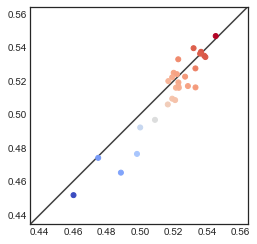

In [587]:
c = th**2 + th1**2

fig, ax = plt.subplots()
ax.scatter(th, th1, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against each other
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [588]:
from sklearn import linear_model

lm = linear_model.LinearRegression()

best = np.array(th)
approx = np.array(th1).reshape(-1, 1)
model = lm.fit(approx,best)

th1p = lm.predict(approx)
print(th1p)

print(lm.intercept_)
print(lm.coef_)
print(lm.score(approx,best))
print('F1 macro: ',f1_score(y, pred>th1p, average='macro'))

[0.539 0.535 0.526 0.523 0.529 0.52  0.537 0.515 0.488 0.481 0.49  0.52  0.535 0.521 0.545 0.47  0.521 0.515 0.527 0.525 0.505 0.527 0.536 0.521 0.524 0.534 0.513 0.502]
0.11779107405273753
[0.781]
0.8935156733261016
F1 macro:  0.7324019212110164


(0.44778871112075025, 0.5608601748192102)

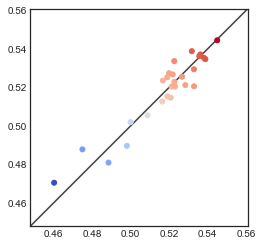

In [589]:
c = th**2 + th1**2

fig, ax = plt.subplots()
ax.scatter(th, th1p, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [590]:
# # estimate thresholds by line search on observed proportions
# def prop_mse(preds, targs, th=0.5):
#     return (np.mean(targs) - np.mean((preds>th)))**2

# def fit_val2(x, y, start=0.5):
#     params = np.array([start])
#     wd = 1e-5
# #     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
#     error = lambda p: np.array(prop_mse(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.,1.0], method='bounded').x
# #     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
# #     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
#     return p

In [591]:
# # estimate thresholds by line search
# def F1_hard(preds, targs, th=0.5):
#     return -f1_score(targs,  (preds>th).astype(int))

# def fit_val1(x, y, start=0.5):
#     params = np.array([start])
#     wd = 1e-5
# #     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
#     error = lambda p: np.array(F1_hard(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.,1.0], method='bounded').x
# #     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
# #     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
#     return p

In [592]:
# pred = x
# num_classes = x.shape[1]
# print(pred.min(),pred.mean(),pred.max(),num_classes)
# name_label_dict = LABEL_MAP
# th = np.zeros(num_classes)
# for i in range(num_classes):
#     th[i] = fit_val2(pred[:,i],y[:,i])
# # th[th<0.1] = 0.1
# print('Thresholds: ',th)
# print('F1 macro: ',f1_score(y, pred>th, average='macro'))
# print('F1 micro: ',f1_score(y, pred>th, average='micro'))

f1_score(y, pred>1.001*th1, average='macro')

0.7286331101705136

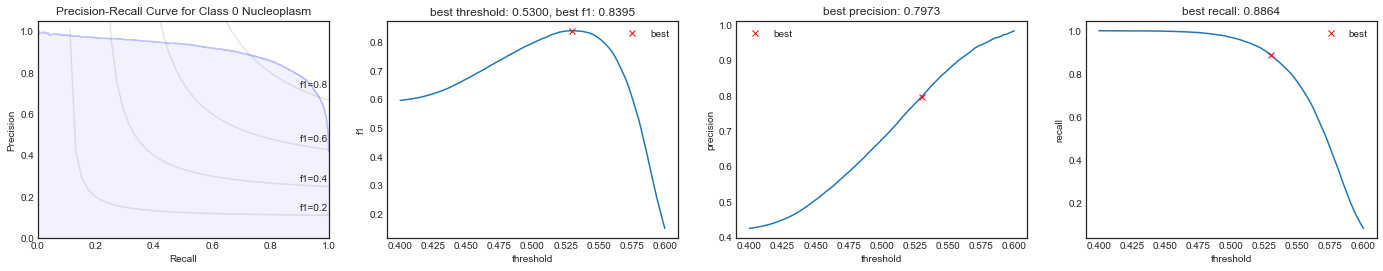

<Figure size 432x288 with 0 Axes>

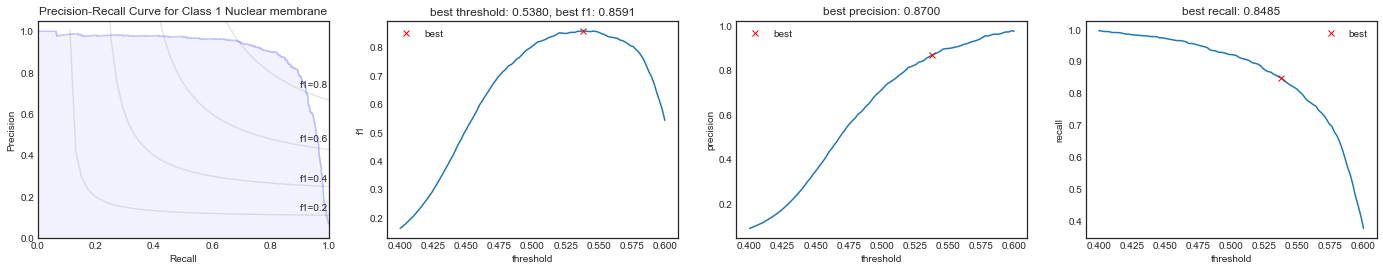

<Figure size 432x288 with 0 Axes>

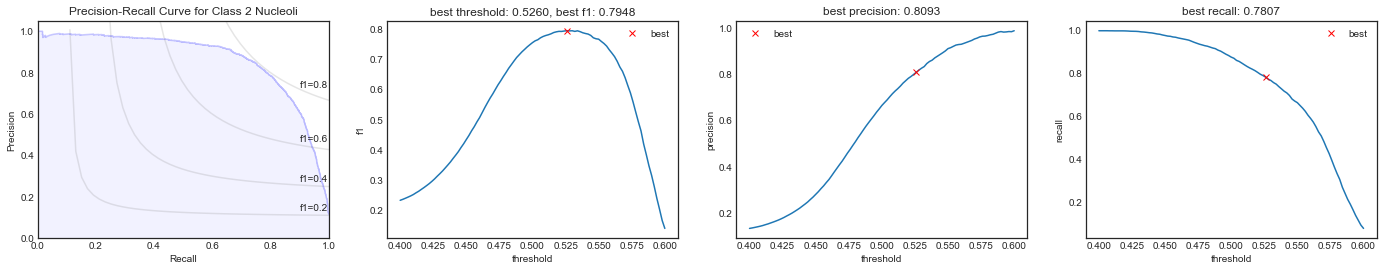

<Figure size 432x288 with 0 Axes>

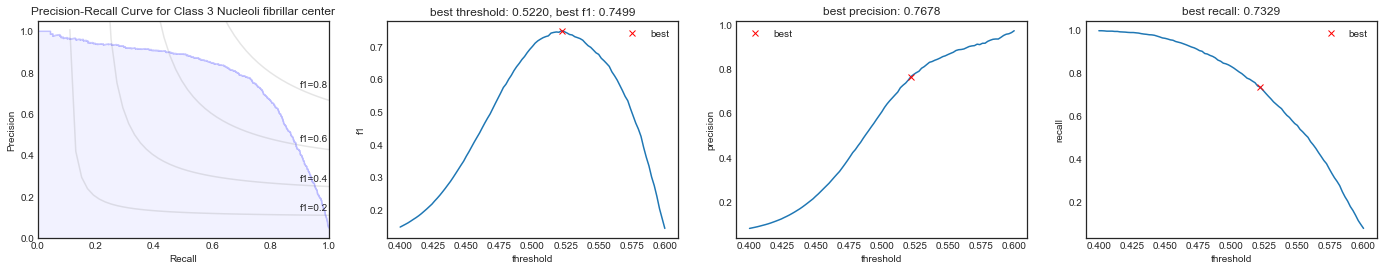

<Figure size 432x288 with 0 Axes>

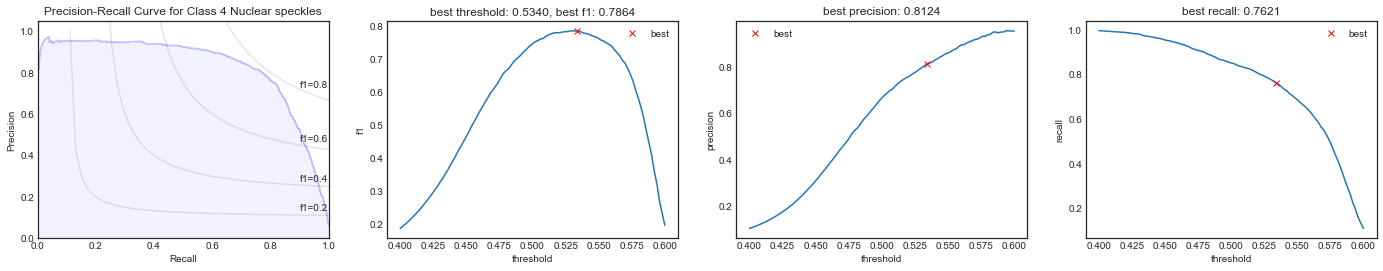

<Figure size 432x288 with 0 Axes>

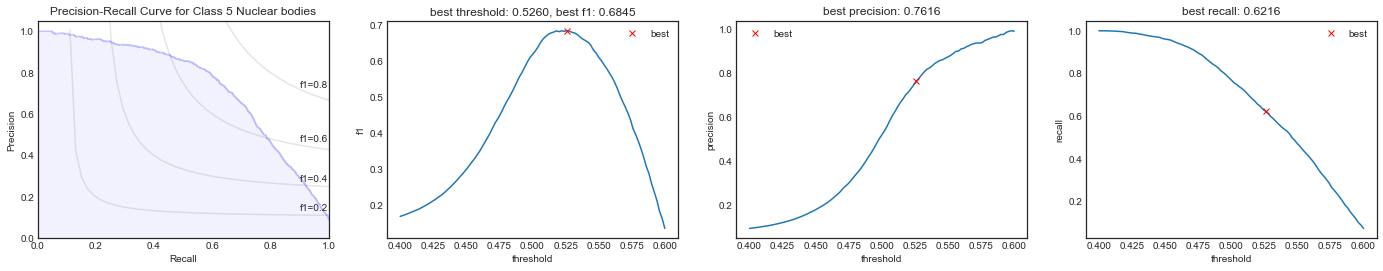

<Figure size 432x288 with 0 Axes>

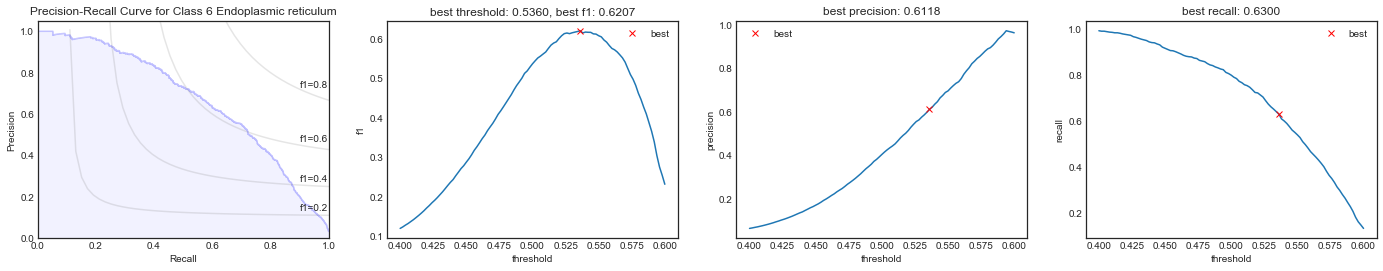

<Figure size 432x288 with 0 Axes>

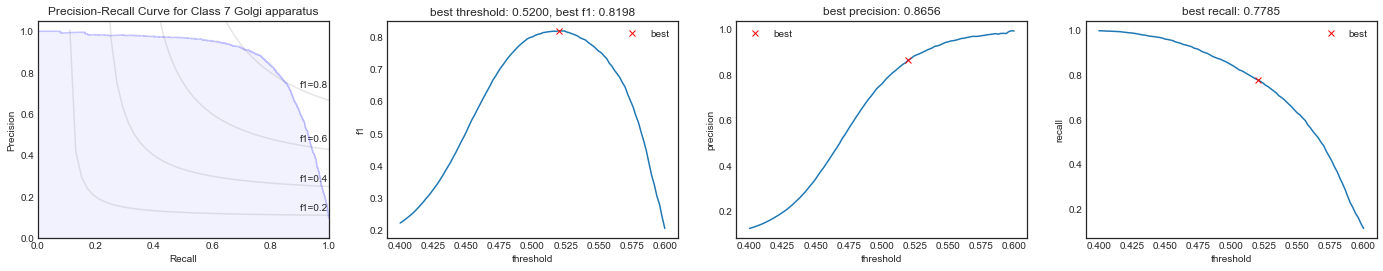

<Figure size 432x288 with 0 Axes>

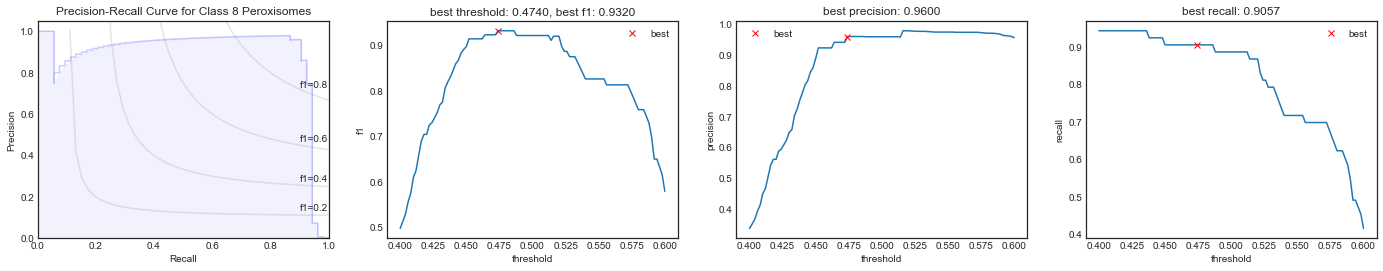

<Figure size 432x288 with 0 Axes>

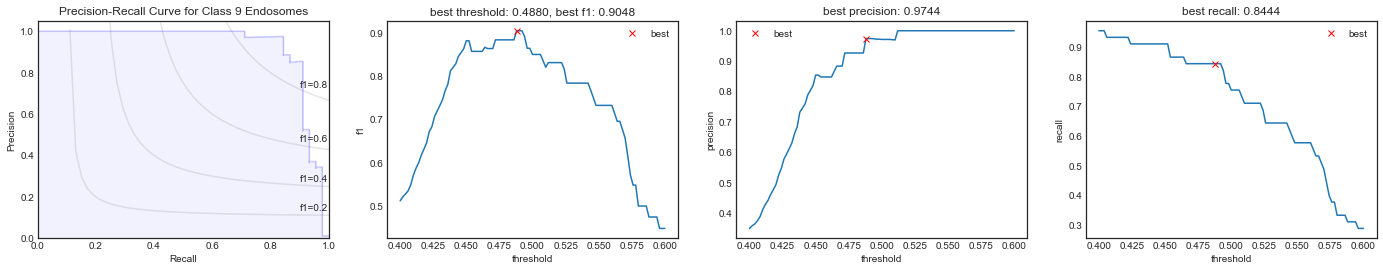

<Figure size 432x288 with 0 Axes>

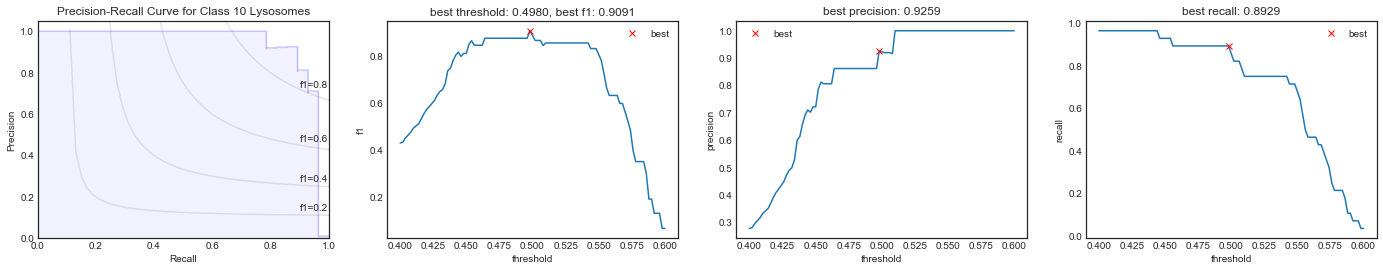

<Figure size 432x288 with 0 Axes>

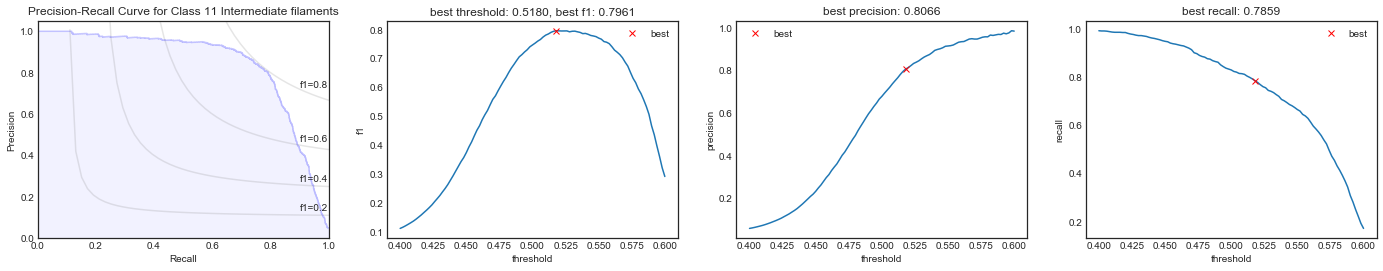

<Figure size 432x288 with 0 Axes>

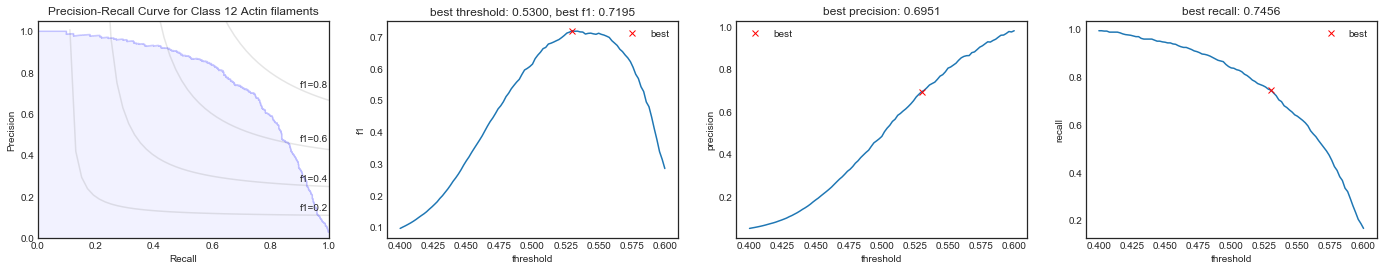

<Figure size 432x288 with 0 Axes>

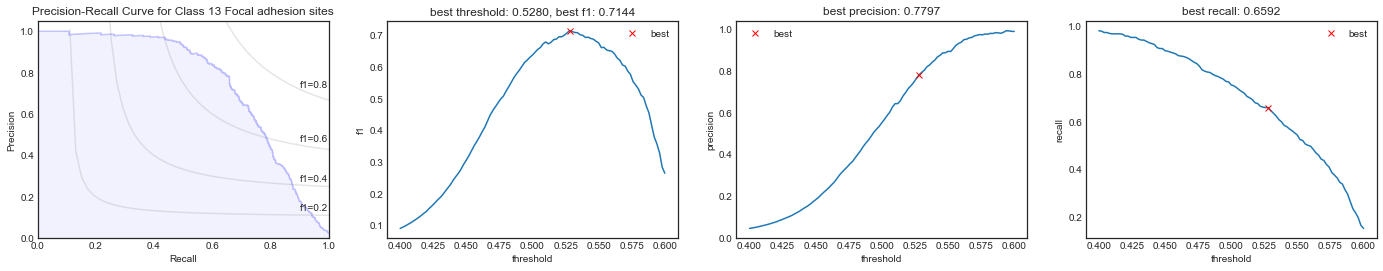

<Figure size 432x288 with 0 Axes>

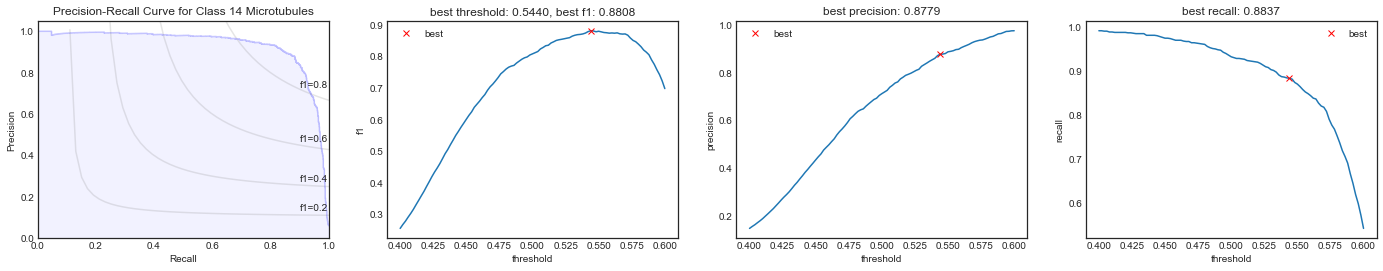

<Figure size 432x288 with 0 Axes>

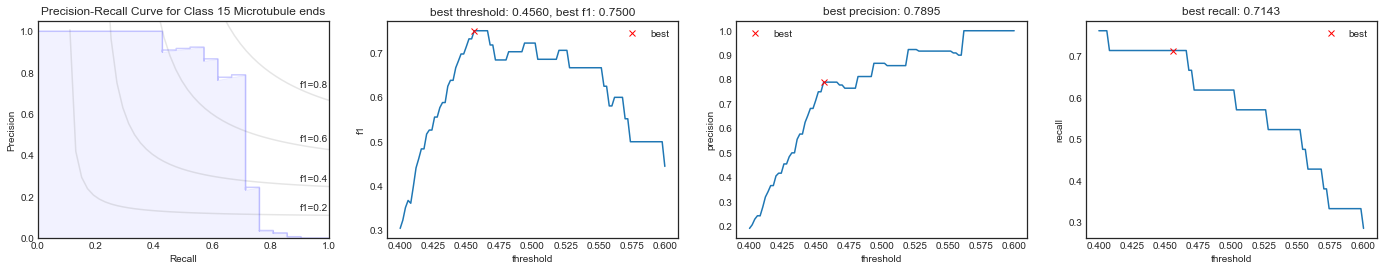

<Figure size 432x288 with 0 Axes>

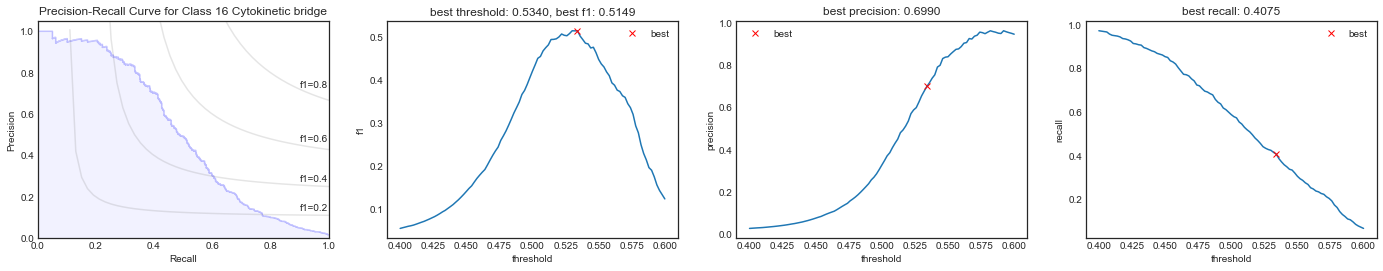

<Figure size 432x288 with 0 Axes>

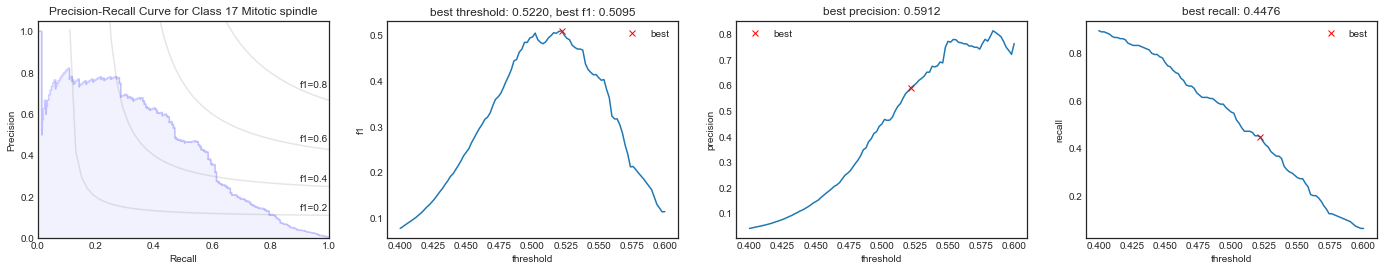

<Figure size 432x288 with 0 Axes>

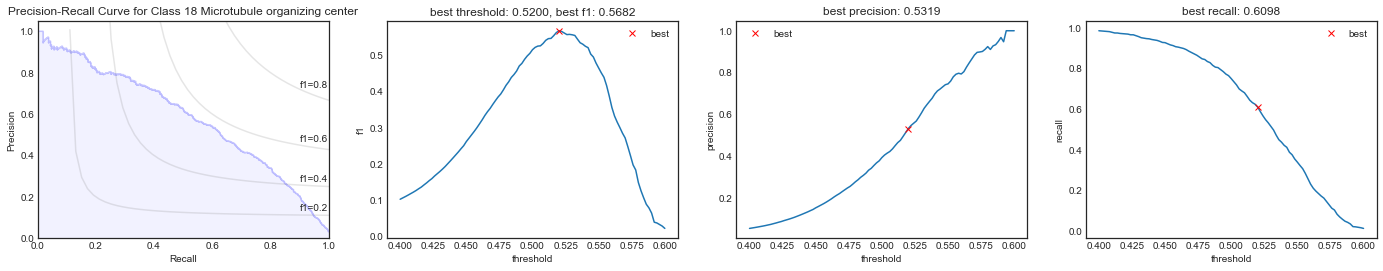

<Figure size 432x288 with 0 Axes>

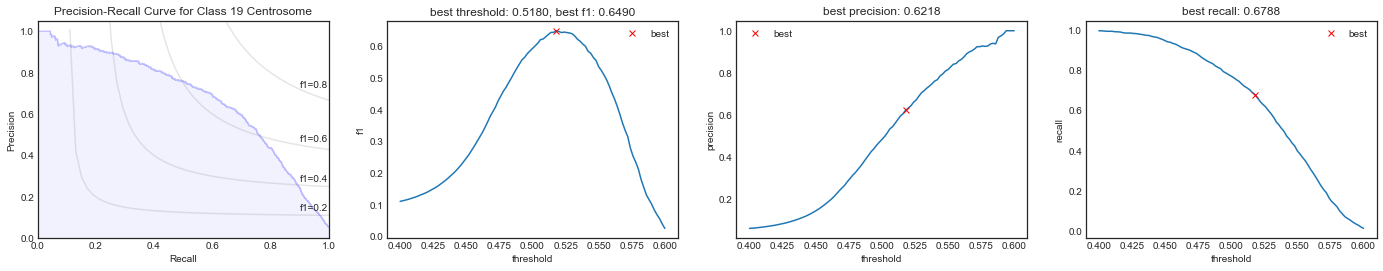

<Figure size 432x288 with 0 Axes>

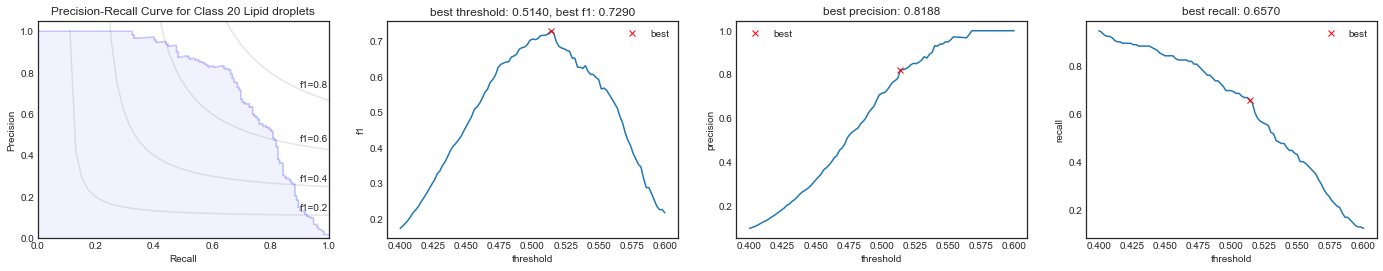

<Figure size 432x288 with 0 Axes>

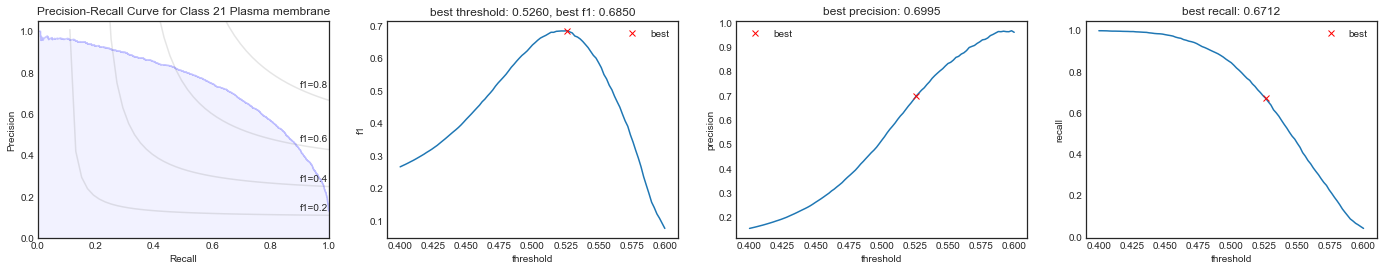

<Figure size 432x288 with 0 Axes>

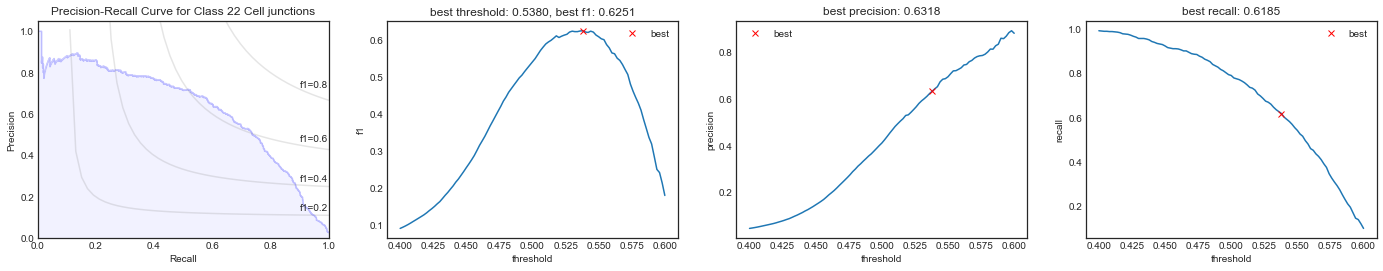

<Figure size 432x288 with 0 Axes>

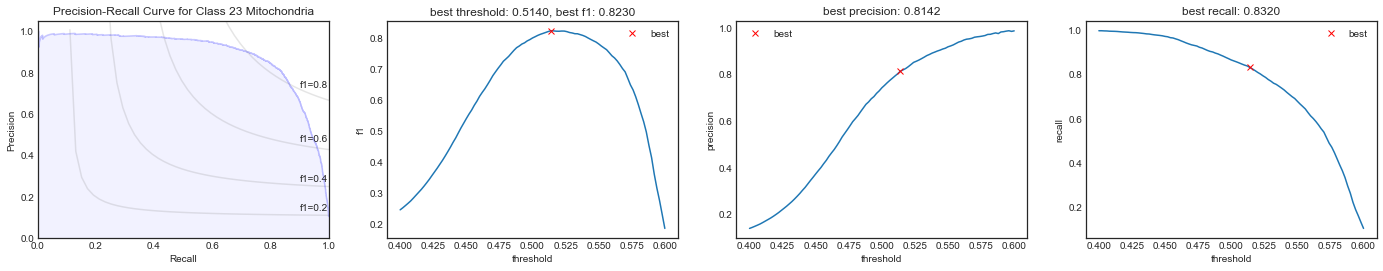

<Figure size 432x288 with 0 Axes>

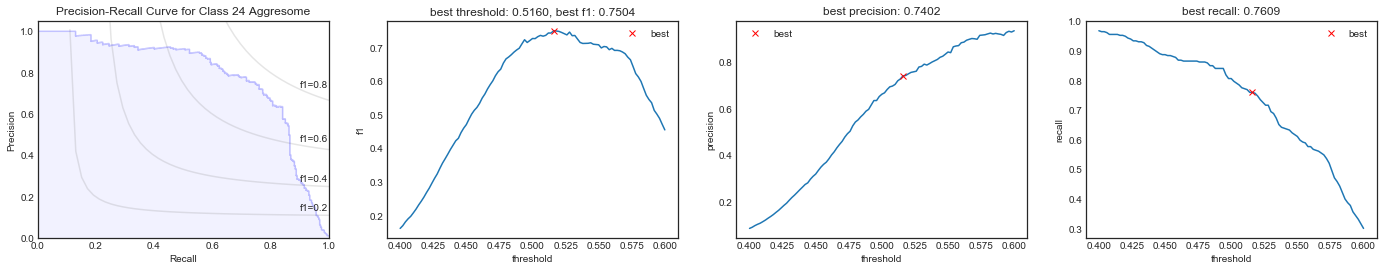

<Figure size 432x288 with 0 Axes>

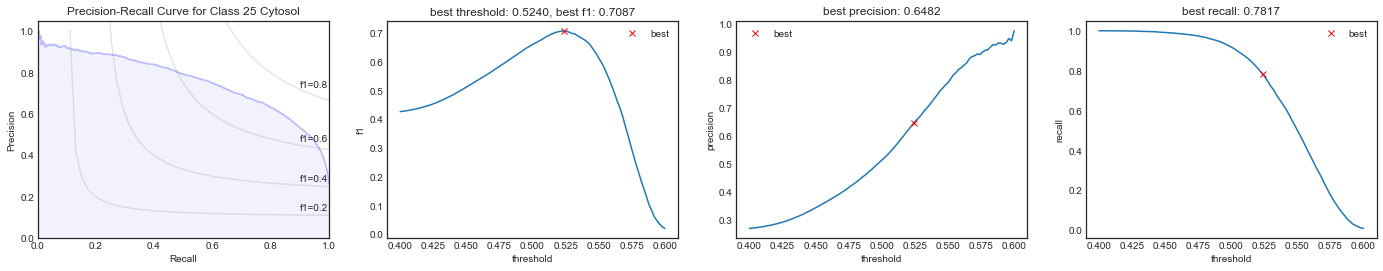

<Figure size 432x288 with 0 Axes>

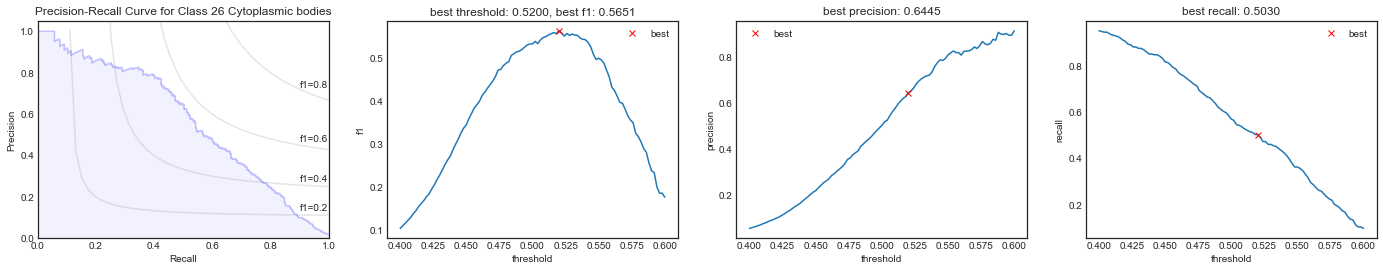

<Figure size 432x288 with 0 Axes>

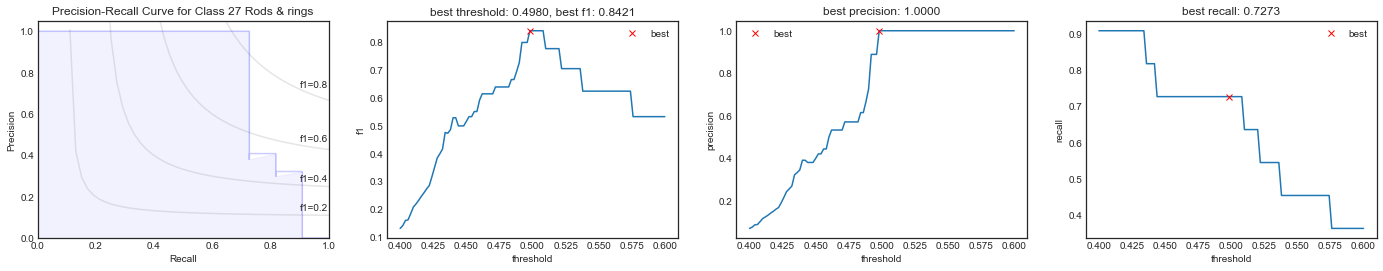

<Figure size 432x288 with 0 Axes>

In [593]:
n_classes = 28

# plot precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
f_scores = np.linspace(0.2, 0.8, num=4)
ta = []
fma = []

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i], bestEnsemble0[:, i])
    average_precision[i] = average_precision_score(y[:, i], bestEnsemble0[:, i])
    
#     plt.figure()
    
#     for f_score in f_scores:
#         xf = np.linspace(0.01, 1)
#         yf = f_score * xf / (2 * xf - f_score)
#         l, = plt.plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

#     plt.step(recall[i], precision[i], color='b', alpha=0.2, where='post')
#     plt.fill_between(recall[i], precision[i], alpha=0.05, color='b')

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title(LABEL_MAP[i])
    
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 4))
    
    for f_score in f_scores:
        xf = np.linspace(0.01, 1)
        yf = f_score * xf / (2 * xf - f_score)
        l, = axs[0].plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
        axs[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

    axs[0].step(recall[i], precision[i], color='b', alpha=0.2, where='post')
    axs[0].fill_between(recall[i], precision[i], alpha=0.05, color='b')

    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_title('Precision-Recall Curve for Class ' + str(i) + ' ' + LABEL_MAP[i])
    
    
    thresholds = np.linspace(0.4, 0.6, 101)
    # for ranks
    # thresholds = np.linspace(0.8, 1.0, 101)
    fm = [f1_score(y[:,i], (bestEnsemble0[:,i] > t).astype(int)) for t in thresholds] 

    besti = np.argmax(fm)
    bestt = thresholds[besti]
    ta.append(bestt)
    bests = fm[besti] 
    fma.append(bests)
        
    axs[1].plot(thresholds, fm)
    axs[1].plot(bestt, bests, "xr", label="best")
    axs[1].set_xlabel("threshold")
    axs[1].set_ylabel("f1")
    axs[1].set_title("best threshold: %6.4f, best f1: %6.4f" % (bestt, bests))
    axs[1].legend()

    pm = [precision_score(y[:,i], (bestEnsemble0[:,i] > t).astype(int)) for t in thresholds] 
    bestsp = pm[besti] 
        
    axs[2].plot(thresholds, pm)
    axs[2].plot(bestt, bestsp, "xr", label="best")
    axs[2].set_xlabel("threshold")
    axs[2].set_ylabel("precision")
    axs[2].set_title("best precision: %6.4f" % (bestsp))
    axs[2].legend()
    
    rm = [recall_score(y[:,i], (bestEnsemble0[:,i] > t).astype(int)) for t in thresholds] 
    bestsr = rm[besti] 
        
    axs[3].plot(thresholds, rm)
    axs[3].plot(bestt, bestsr, "xr", label="best")
    axs[3].set_xlabel("threshold")
    axs[3].set_ylabel("recall")
    axs[3].set_title("best recall: %6.4f" % (bestsr))
    axs[3].legend()
    
    plt.show()
    plt.gcf().clear()

In [594]:
np.mean(fma)

0.7404091606549181

In [595]:
# error analysis
from sklearn.metrics import confusion_matrix

cm = [confusion_matrix(y[:,i], (bestEnsemble0[:,i]  > th[i]).astype(int)) \
       for i in range(y.shape[1])]
pma = [precision_score(y[:,i], (bestEnsemble0[:,i]  > th[i]).astype(int)) \
       for i in range(y.shape[1])]
rma = [recall_score(y[:,i], (bestEnsemble0[:,i]  > th[i]).astype(int)) \
       for i in range(y.shape[1])]

print('macro f1','%6.4f' % np.mean(fma))
print()

# sort from worst to best
order = np.array(fma).argsort()
ymean = np.mean(y,axis=0)

for i in range(y.shape[1]):
    oi = order[i]
    print('class', '%2d' % oi,'  prop', '%6.4f' % ymean[oi], 
                     '  f1', '%6.4f' % fma[oi],
                     '  precision', '%6.4f' % pma[oi],
                     '  recall', '%6.4f' % rma[oi],
                     '  ', LABEL_MAP[oi])
    print(cm[oi])
    print()

macro f1 0.7404

class 17   prop 0.0068   f1 0.5095   precision 0.5864   recall 0.4524    Mitotic spindle
[[30795    67]
 [  115    95]]

class 16   prop 0.0171   f1 0.5149   precision 0.6909   recall 0.4132    Cytokinetic bridge
[[30444    98]
 [  311   219]]

class 26   prop 0.0106   f1 0.5651   precision 0.6245   recall 0.5122    Cytoplasmic bodies
[[30643   101]
 [  160   168]]

class 18   prop 0.0290   f1 0.5682   precision 0.5319   recall 0.6098    Microtubule organizing center
[[29686   484]
 [  352   550]]

class  6   prop 0.0324   f1 0.6207   precision 0.6155   recall 0.6290    Endoplasmic reticulum
[[29668   396]
 [  374   634]]

class 22   prop 0.0258   f1 0.6251   precision 0.6219   recall 0.6297    Cell junctions
[[29963   307]
 [  297   505]]

class 19   prop 0.0477   f1 0.6490   precision 0.6286   recall 0.6680    Centrosome
[[29005   585]
 [  492   990]]

class  5   prop 0.0809   f1 0.6845   precision 0.7385   recall 0.6383    Nuclear bodies
[[27991   568]
 [  909  1604

In [596]:
# confusion matrix of true val with single label
true_list = []
pred_list = []
for i, yi in enumerate(y):
#     img, y = db_val[i]

    true = np.nonzero(yi)[0]
    if len(true) > 1: continue
    
    pred = np.nonzero((bestEnsemble[i] > threshold_best).astype(int))[0]
    if len(pred)==0: pred = np.array([28])
    # replace empty with max prob
    # if len(pred)==0: pred = [np.argmax(vlsp[i])]
    for j in range(len(pred)):
        true_list.append(true[0])
        pred_list.append(pred[j])
    
print(y.shape[0],len(true_list),len(pred_list))

true = np.array(true_list)
pred = np.array(pred_list)
print(true.shape,true[:5])

np.set_printoptions(linewidth=250)
cm = confusion_matrix(true,pred)
print(cm)

31072 34699 34699
(34699,) [5 5 5 5 1]
[[2385   90  276  108  316  807    5   91    0    0    0   13   11   13   15  151   25   71  220    3  247   80   73   15 1189   32    0    3]
 [ 156  268   12    0    0    7   12    1    0    0    0    1    1    0    0    0    0    2    3    0    4    0    1    0   75    0    0    0]
 [ 445    5  750  144   21   48    1   16    0    0    0    5    8    1   11   12    1   21   15    0   41    7   23    0  234    5    0    5]
 [ 279    6  308  600   13   83   15    7    0    0    0    1    1    0    0    2    0    1    4    0   19    5   18    0  158    1    0    0]
 [ 459    2   56   28  983   99    1   21    0    0    0    2    4    5    4    6    0    6   19    0   39    6   25    1  238   21    2    2]
 [ 707   19   46   96  107  892    4   18    0    0    0    1   12    2    4    9    1   35   84    0   31   14   28   14  298    9    0    2]
 [  91   41   12    2    3   13  548    6    0    0    0   32    3    0   25    7    3    6    7    2  


score_best 0.724045215824651
threshold_best 0.52



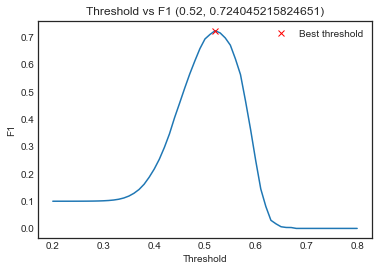

               mod   mean_f1
19      resnet_u60  0.733652
13         iv3_u12  0.733546
17      resnet_u31  0.732951
20     resnet_u101  0.732891
18      resnet_u56  0.731439
15      resnet_q27  0.731032
23          bni_u2  0.730962
11         iv3_q12  0.729870
14      resnet_q26  0.729590
4       resnet_q40  0.728932
1         irv2_q10  0.728614
12         iv3_u11  0.728164
2       resnet_q24  0.727938
0          iv3_q11  0.727764
3       resnet_q25  0.727755
22          bni_u1  0.727296
9           bni_q0  0.727294
10          bni_q1  0.727096
16      resnet_u25  0.727022
8   se_resnext_q28  0.726044
21         gap_u14  0.725851
6          nas_q11  0.723112
5          gap_q12  0.722247
7   se_resnext_q26  0.721547


<Figure size 432x288 with 0 Axes>

In [597]:
# tb = table(rez$index[1:bestStep])
# names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

# if (intercept!=0) {
#   tb["Intercept"] = intercept
# }

# print(tb[order(-tb)])
# print(single[order(-single[,2]),][1:min(nrow(single),40),])

# # plot hillclimbing
# ggplot(data=rez, aes(x=step, y=score)) + 
#   geom_line(size=.75) + geom_point()  


# replace empty predictions with class having max probability
def tmax1(vlsp, t):
    rez = (vlsp > t).astype(int)
    rezm = np.sum(rez,axis=1)
    z = np.where(rezm==0)[0]
    for i in z:
        rez[i,np.argmax(vlsp[i])] = 1
    return rez
        
# compute best threshold for computed ensemble
thresholds = np.linspace(0.2, 0.8, 61)
# thresholds = np.linspace(-2, 2, 41)
# thresholds = np.linspace(-0.2, 0.2, 41)

scores = np.array([f1_score(y, np.int32(bestEnsemble > threshold),
                        average='macro') for threshold in thresholds])

# scores = np.array([f1_score(y, tmax1(bestEnsemble, threshold),
#                         average='macro') for threshold in thresholds])


# ious = np.array([iou_metric_batch(train_df.masks, np.int32(bestEnsemble > threshold), \
#                                   pred_eps=pred_eps) for threshold in thresholds])

# threshold_best_index = np.argmax(ious[9:-10]) + 9
threshold_best_index = np.argmax(scores)
score_best = scores[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('')
print('score_best',score_best)
print('threshold_best',threshold_best)
print('')

plt.plot(thresholds, scores)
plt.plot(threshold_best, score_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Threshold vs F1 ({}, {})".format(threshold_best, score_best))
plt.legend()
plt.show()
plt.gcf().clear()

single['mean_'+metric] = single.iloc[:,1:].mean(axis=1)
single.sort_values('mean_'+metric,ascending=False,inplace=True)
print(single.loc[:,['mod','mean_'+metric]])

In [598]:
print(y.shape)
yis = np.array([yi for yi in y if len(np.nonzero(yi)[0])==1 ])
print(yis.shape)
yism = np.mean(yis,axis=0)


(31072, 28)
(15126, 28)


(-0.028576243238916825, 0.4436122904074585)

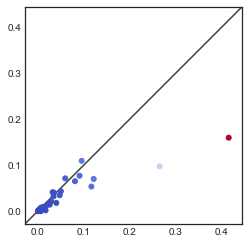

In [599]:
c = ymean**2 + yism**2

fig, ax = plt.subplots()
ax.scatter(ymean, yism, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)



hillclimbing for class 0 Nucleoplasm

model 0 f1 0.8240 cut 0.5637 iv3_q11
model 1 f1 0.8062 cut 0.5196 irv2_q10
model 2 f1 0.8133 cut 0.5175 resnet_q24
model 3 f1 0.8094 cut 0.5174 resnet_q25
model 4 f1 0.8066 cut 0.5191 resnet_q40
model 5 f1 0.8016 cut 0.5194 gap_q12
model 6 f1 0.7906 cut 0.4942 nas_q11
model 7 f1 0.7834 cut 0.4994 se_resnext_q26
model 8 f1 0.7989 cut 0.5057 se_resnext_q28
model 9 f1 0.7994 cut 0.5161 bni_q0
model 10 f1 0.8016 cut 0.5176 bni_q1
model 11 f1 0.8239 cut 0.5689 iv3_q12
model 12 f1 0.8149 cut 0.5186 iv3_u11
model 13 f1 0.8196 cut 0.5392 iv3_u12
model 14 f1 0.7864 cut 0.4742 resnet_q26
model 15 f1 0.8220 cut 0.5212 resnet_q27
model 16 f1 0.8119 cut 0.5177 resnet_u25
model 17 f1 0.7987 cut 0.5084 resnet_u31
model 18 f1 0.8253 cut 0.5493 resnet_u56
model 19 f1 0.8135 cut 0.5359 resnet_u60
model 20 f1 0.8230 cut 0.5463 resnet_u101
model 21 f1 0.8108 cut 0.5403 gap_u14
model 22 f1 0.8080 cut 0.5254 bni_u1
model 23 f1 0.8196 cut 0.5543 bni_u2
step = 0    f1 =

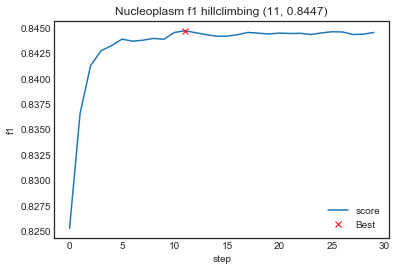

    step  midx     score          mod      f1_0
0      0    18  0.825270   resnet_u56  0.825270
1      1    15  0.836564   resnet_q27  0.821979
2      2    19  0.841284   resnet_u60  0.813495
3      3    15  0.842762   resnet_q27  0.821979
4      4    11  0.843267      iv3_q12  0.823880
5      5    13  0.843910      iv3_u12  0.819621
6      6    15  0.843703   resnet_q27  0.821979
7      7    19  0.843806   resnet_u60  0.813495
8      8    20  0.843977  resnet_u101  0.823031
9      9    11  0.843898      iv3_q12  0.823880
10    10    19  0.844566   resnet_u60  0.813495
11    11    15  0.844734   resnet_q27  0.821979

      weight          mod      f1_0
midx                               
11         2      iv3_q12  0.823880
13         1      iv3_u12  0.819621
15         4   resnet_q27  0.821979
18         1   resnet_u56  0.825270
19         3   resnet_u60  0.813495
20         1  resnet_u101  0.823031


hillclimbing for class 1 Nuclear membrane

model 0 f1 0.8284 cut 0.5918 iv3_q11
model

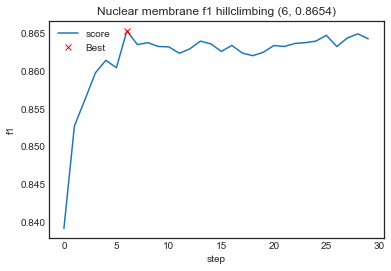

   step  midx     score          mod      f1_0
0     0    18  0.839155   resnet_u56  0.839155
1     1    16  0.852744   resnet_u25  0.828900
2     2    17  0.856214   resnet_u31  0.795618
3     3    20  0.859776  resnet_u101  0.834521
4     4    16  0.861441   resnet_u25  0.828900
5     5    20  0.860447  resnet_u101  0.834521
6     6    15  0.865362   resnet_q27  0.824458

      weight          mod      f1_0
midx                               
15         1   resnet_q27  0.824458
16         2   resnet_u25  0.828900
17         1   resnet_u31  0.795618
18         1   resnet_u56  0.839155
20         2  resnet_u101  0.834521


hillclimbing for class 2 Nucleoli

model 0 f1 0.7612 cut 0.5660 iv3_q11
model 1 f1 0.7474 cut 0.5203 irv2_q10
model 2 f1 0.7455 cut 0.5161 resnet_q24
model 3 f1 0.7377 cut 0.5109 resnet_q25
model 4 f1 0.7289 cut 0.5149 resnet_q40
model 5 f1 0.7153 cut 0.5460 gap_q12
model 6 f1 0.6518 cut 0.4885 nas_q11
model 7 f1 0.6890 cut 0.5312 se_resnext_q26
model 8 f1 0.7116 cut

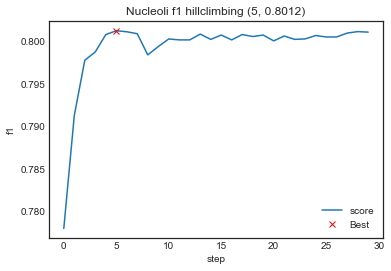

   step  midx     score          mod      f1_0
0     0    20  0.777980  resnet_u101  0.777980
1     1    19  0.791269   resnet_u60  0.776230
2     2    11  0.797770      iv3_q12  0.767886
3     3    17  0.798755   resnet_u31  0.726289
4     4    19  0.800793   resnet_u60  0.776230
5     5    11  0.801247      iv3_q12  0.767886

      weight          mod      f1_0
midx                               
11         2      iv3_q12  0.767886
17         1   resnet_u31  0.726289
19         2   resnet_u60  0.776230
20         1  resnet_u101  0.777980


hillclimbing for class 3 Nucleoli fibrillar center

model 0 f1 0.6299 cut 0.5688 iv3_q11
model 1 f1 0.5695 cut 0.5102 irv2_q10
model 2 f1 0.6103 cut 0.5190 resnet_q24
model 3 f1 0.6079 cut 0.5159 resnet_q25
model 4 f1 0.5827 cut 0.5170 resnet_q40
model 5 f1 0.5627 cut 0.5687 gap_q12
model 6 f1 0.3765 cut 0.4837 nas_q11
model 7 f1 0.5184 cut 0.5558 se_resnext_q26
model 8 f1 0.5782 cut 0.5612 se_resnext_q28
model 9 f1 0.5839 cut 0.5132 bni_q0
model 1

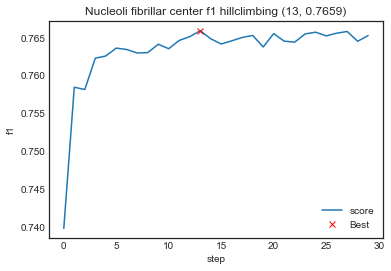

    step  midx     score          mod      f1_0
0      0    19  0.739798   resnet_u60  0.739798
1      1    20  0.758464  resnet_u101  0.719476
2      2    19  0.758157   resnet_u60  0.739798
3      3    18  0.762295   resnet_u56  0.706152
4      4    19  0.762594   resnet_u60  0.739798
5      5    18  0.763636   resnet_u56  0.706152
6      6    19  0.763451   resnet_u60  0.739798
7      7    19  0.762984   resnet_u60  0.739798
8      8    17  0.763042   resnet_u31  0.683472
9      9    15  0.764145   resnet_q27  0.652389
10    10    20  0.763555  resnet_u101  0.719476
11    11    19  0.764650   resnet_u60  0.739798
12    12    19  0.765152   resnet_u60  0.739798
13    13    17  0.765931   resnet_u31  0.683472

      weight          mod      f1_0
midx                               
15         1   resnet_q27  0.652389
17         2   resnet_u31  0.683472
18         2   resnet_u56  0.706152
19         7   resnet_u60  0.739798
20         2  resnet_u101  0.719476


hillclimbing for class 4 

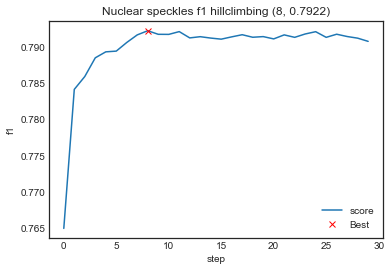

   step  midx     score         mod      f1_0
0     0    18  0.765019  resnet_u56  0.765019
1     1    17  0.784163  resnet_u31  0.726928
2     2    11  0.785934     iv3_q12  0.753005
3     3    18  0.788509  resnet_u56  0.765019
4     4    16  0.789330  resnet_u25  0.744395
5     5    19  0.789431  resnet_u60  0.754899
6     6    13  0.790621     iv3_u12  0.753981
7     7    11  0.791667     iv3_q12  0.753005
8     8    12  0.792236     iv3_u11  0.755218

      weight         mod      f1_0
midx                              
11         2     iv3_q12  0.753005
12         1     iv3_u11  0.755218
13         1     iv3_u12  0.753981
16         1  resnet_u25  0.744395
17         1  resnet_u31  0.726928
18         2  resnet_u56  0.765019
19         1  resnet_u60  0.754899


hillclimbing for class 5 Nuclear bodies

model 0 f1 0.5938 cut 0.5660 iv3_q11
model 1 f1 0.5503 cut 0.5201 irv2_q10
model 2 f1 0.5621 cut 0.5165 resnet_q24
model 3 f1 0.5638 cut 0.5175 resnet_q25
model 4 f1 0.5351 cut 0.51

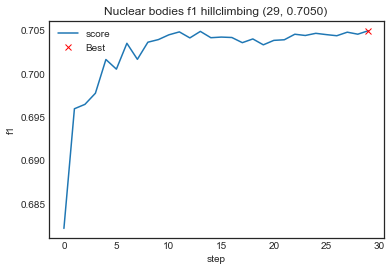

    step  midx     score          mod      f1_0
0      0    19  0.682164   resnet_u60  0.682164
1      1    15  0.695980   resnet_q27  0.586758
2      2    17  0.696486   resnet_u31  0.647579
3      3    19  0.697770   resnet_u60  0.682164
4      4    13  0.701668      iv3_u12  0.613063
5      5    19  0.700553   resnet_u60  0.682164
6      6    18  0.703537   resnet_u56  0.639369
7      7    18  0.701688   resnet_u56  0.639369
8      8    19  0.703664   resnet_u60  0.682164
9      9    11  0.703966      iv3_q12  0.606036
10    10    19  0.704516   resnet_u60  0.682164
11    11    19  0.704855   resnet_u60  0.682164
12    12    19  0.704160   resnet_u60  0.682164
13    13    15  0.704911   resnet_q27  0.586758
14    14    17  0.704183   resnet_u31  0.647579
15    15    18  0.704255   resnet_u56  0.639369
16    16    11  0.704207      iv3_q12  0.606036
17    17    15  0.703610   resnet_q27  0.586758
18    18    17  0.704041   resnet_u31  0.647579
19    19    11  0.703361      iv3_q12  0

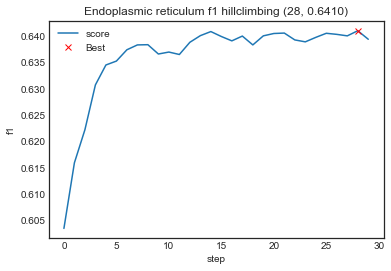

    step  midx     score             mod      f1_0
0      0    15  0.603448      resnet_q27  0.603448
1      1    11  0.615924         iv3_q12  0.584964
2      2    13  0.622199         iv3_u12  0.587090
3      3    15  0.630722      resnet_q27  0.603448
4      4    17  0.634504      resnet_u31  0.556006
5      5     2  0.635248      resnet_q24  0.568296
6      6     1  0.637395        irv2_q10  0.552657
7      7    15  0.638319      resnet_q27  0.603448
8      8    11  0.638362         iv3_q12  0.584964
9      9    15  0.636591      resnet_q27  0.603448
10    10    17  0.636962      resnet_u31  0.556006
11    11    13  0.636499         iv3_u12  0.587090
12    12    11  0.638818         iv3_q12  0.584964
13    13    15  0.640082      resnet_q27  0.603448
14    14    15  0.640856      resnet_q27  0.603448
15    15    14  0.639919      resnet_q26  0.559205
16    16    23  0.639090          bni_u2  0.568932
17    17     8  0.640000  se_resnext_q28  0.571872
18    18    14  0.638320      r

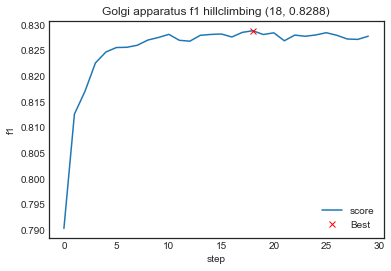

    step  midx     score          mod      f1_0
0      0    20  0.790326  resnet_u101  0.790326
1      1    15  0.812593   resnet_q27  0.776294
2      2    19  0.817007   resnet_u60  0.786848
3      3    11  0.822554      iv3_q12  0.786957
4      4    19  0.824697   resnet_u60  0.786848
5      5    15  0.825566   resnet_q27  0.776294
6      6    18  0.825618   resnet_u56  0.789542
7      7    17  0.826015   resnet_u31  0.774462
8      8    19  0.827026   resnet_u60  0.786848
9      9    11  0.827522      iv3_q12  0.786957
10    10    20  0.828137  resnet_u101  0.790326
11    11    15  0.826973   resnet_q27  0.776294
12    12    19  0.826803   resnet_u60  0.786848
13    13    19  0.827953   resnet_u60  0.786848
14    14    11  0.828119      iv3_q12  0.786957
15    15    19  0.828205   resnet_u60  0.786848
16    16    15  0.827624   resnet_q27  0.776294
17    17    18  0.828524   resnet_u56  0.789542
18    18    15  0.828839   resnet_q27  0.776294

      weight          mod      f1_0
mid

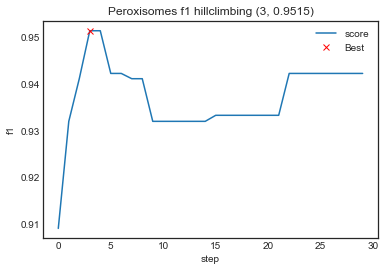

   step  midx     score          mod      f1_0
0     0    18  0.909091   resnet_u56  0.909091
1     1    17  0.932039   resnet_u31  0.871287
2     2    20  0.941176  resnet_u101  0.909091
3     3    17  0.951456   resnet_u31  0.871287

      weight          mod      f1_0
midx                               
17         2   resnet_u31  0.871287
18         1   resnet_u56  0.909091
20         1  resnet_u101  0.909091


hillclimbing for class 9 Endosomes

model 0 f1 0.6250 cut 0.4902 iv3_q11
model 1 f1 0.6667 cut 0.5095 irv2_q10
model 2 f1 0.5974 cut 0.5049 resnet_q24
model 3 f1 0.6067 cut 0.4729 resnet_q25
model 4 f1 0.6588 cut 0.4961 resnet_q40
model 5 f1 0.7027 cut 0.5644 gap_q12
model 6 f1 0.5618 cut 0.4843 nas_q11
model 7 f1 0.6761 cut 0.5427 se_resnext_q26
model 8 f1 0.7250 cut 0.4936 se_resnext_q28
model 9 f1 0.7317 cut 0.4744 bni_q0
model 10 f1 0.6316 cut 0.4798 bni_q1
model 11 f1 0.5915 cut 0.5108 iv3_q12
model 12 f1 0.7619 cut 0.4875 iv3_u11
model 13 f1 0.8571 cut 0.5472 iv3_u12
mo

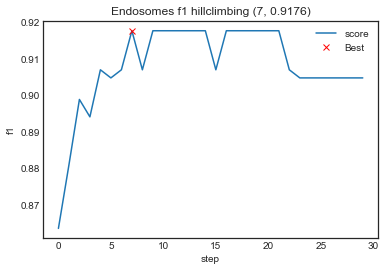

   step  midx     score         mod      f1_0
0     0    17  0.863636  resnet_u31  0.863636
1     1    13  0.880952     iv3_u12  0.857143
2     2     3  0.898876  resnet_q25  0.606742
3     3    17  0.894118  resnet_u31  0.863636
4     4    19  0.906977  resnet_u60  0.829268
5     5    13  0.904762     iv3_u12  0.857143
6     6    17  0.906977  resnet_u31  0.863636
7     7    13  0.917647     iv3_u12  0.857143

      weight         mod      f1_0
midx                              
3          1  resnet_q25  0.606742
13         3     iv3_u12  0.857143
17         3  resnet_u31  0.863636
19         1  resnet_u60  0.829268


hillclimbing for class 10 Lysosomes

model 0 f1 0.6400 cut 0.4946 iv3_q11
model 1 f1 0.6786 cut 0.4768 irv2_q10
model 2 f1 0.6154 cut 0.4561 resnet_q24
model 3 f1 0.5429 cut 0.4525 resnet_q25
model 4 f1 0.5185 cut 0.4495 resnet_q40
model 5 f1 0.6512 cut 0.5472 gap_q12
model 6 f1 0.5263 cut 0.4787 nas_q11
model 7 f1 0.5500 cut 0.5421 se_resnext_q26
model 8 f1 0.5574 cut 0

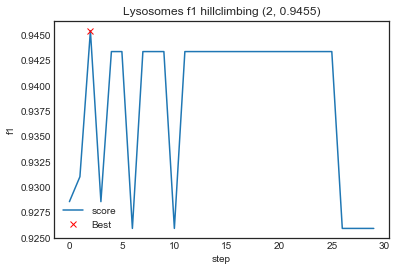

   step  midx     score          mod      f1_0
0     0    20  0.928571  resnet_u101  0.928571
1     1    17  0.931034   resnet_u31  0.862745
2     2     0  0.945455      iv3_q11  0.640000

      weight          mod      f1_0
midx                               
0          1      iv3_q11  0.640000
17         1   resnet_u31  0.862745
20         1  resnet_u101  0.928571


hillclimbing for class 11 Intermediate filaments

model 0 f1 0.7348 cut 0.5810 iv3_q11
model 1 f1 0.7158 cut 0.5185 irv2_q10
model 2 f1 0.7248 cut 0.5115 resnet_q24
model 3 f1 0.6882 cut 0.5236 resnet_q25
model 4 f1 0.7252 cut 0.5063 resnet_q40
model 5 f1 0.7139 cut 0.5782 gap_q12
model 6 f1 0.5888 cut 0.4922 nas_q11
model 7 f1 0.6815 cut 0.5625 se_resnext_q26
model 8 f1 0.7032 cut 0.5578 se_resnext_q28
model 9 f1 0.7025 cut 0.5182 bni_q0
model 10 f1 0.6915 cut 0.5231 bni_q1
model 11 f1 0.7526 cut 0.5790 iv3_q12
model 12 f1 0.7271 cut 0.5217 iv3_u11
model 13 f1 0.7516 cut 0.5621 iv3_u12
model 14 f1 0.6586 cut 0.4765 resne

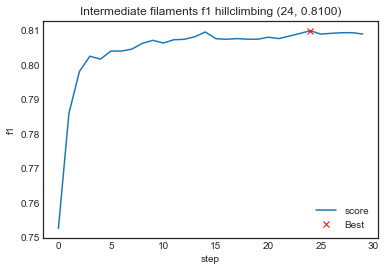

    step  midx     score             mod      f1_0
0      0    11  0.752552         iv3_q12  0.752552
1      1    13  0.785955         iv3_u12  0.751618
2      2    17  0.798113      resnet_u31  0.674688
3      3    14  0.802560      resnet_q26  0.658627
4      4    18  0.801724      resnet_u56  0.738713
5      5     4  0.804044      resnet_q40  0.725215
6      6     7  0.804054  se_resnext_q26  0.681538
7      7    19  0.804631      resnet_u60  0.723446
8      8    11  0.806313         iv3_q12  0.752552
9      9    16  0.807171      resnet_u25  0.706801
10    10    13  0.806389         iv3_u12  0.751618
11    11    18  0.807339      resnet_u56  0.738713
12    12    12  0.807471         iv3_u11  0.727104
13    13     4  0.808226      resnet_q40  0.725215
14    14    15  0.809592      resnet_q27  0.706280
15    15    18  0.807656      resnet_u56  0.738713
16    16    11  0.807471         iv3_q12  0.752552
17    17     6  0.807674         nas_q11  0.588823
18    18     7  0.807507  se_re

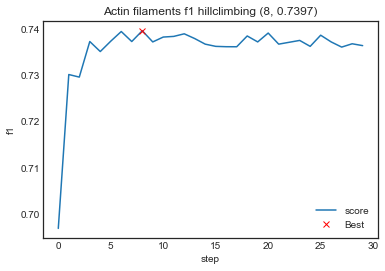

   step  midx     score          mod      f1_0
0     0    18  0.696859   resnet_u56  0.696859
1     1    16  0.730183   resnet_u25  0.670134
2     2    20  0.729627  resnet_u101  0.673851
3     3    12  0.737327      iv3_u11  0.673668
4     4    12  0.735160      iv3_u11  0.673668
5     5    18  0.737405   resnet_u56  0.696859
6     6    16  0.739496   resnet_u25  0.670134
7     7    20  0.737327  resnet_u101  0.673851
8     8    12  0.739663      iv3_u11  0.673668

      weight          mod      f1_0
midx                               
12         3      iv3_u11  0.673668
16         2   resnet_u25  0.670134
18         2   resnet_u56  0.696859
20         2  resnet_u101  0.673851


hillclimbing for class 13 Focal adhesion sites

model 0 f1 0.6204 cut 0.5935 iv3_q11
model 1 f1 0.6107 cut 0.5304 irv2_q10
model 2 f1 0.6190 cut 0.5334 resnet_q24
model 3 f1 0.6225 cut 0.5301 resnet_q25
model 4 f1 0.6224 cut 0.5292 resnet_q40
model 5 f1 0.6032 cut 0.5935 gap_q12
model 6 f1 0.4559 cut 0.5022 na

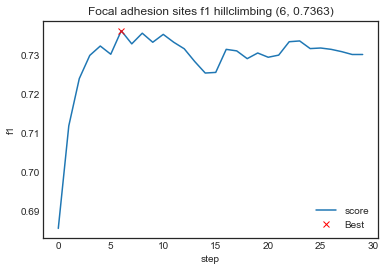

   step  midx     score          mod      f1_0
0     0    18  0.685547   resnet_u56  0.685547
1     1    13  0.711864      iv3_u12  0.669492
2     2    20  0.724000  resnet_u101  0.676190
3     3    12  0.729958      iv3_u11  0.596050
4     4    19  0.732365   resnet_u60  0.602410
5     5    20  0.730256  resnet_u101  0.676190
6     6    13  0.736287      iv3_u12  0.669492

      weight          mod      f1_0
midx                               
12         1      iv3_u11  0.596050
13         2      iv3_u12  0.669492
18         1   resnet_u56  0.685547
19         1   resnet_u60  0.602410
20         2  resnet_u101  0.676190


hillclimbing for class 14 Microtubules

model 0 f1 0.8562 cut 0.6029 iv3_q11
model 1 f1 0.8434 cut 0.5378 irv2_q10
model 2 f1 0.8645 cut 0.5364 resnet_q24
model 3 f1 0.8520 cut 0.5365 resnet_q25
model 4 f1 0.8602 cut 0.5304 resnet_q40
model 5 f1 0.8481 cut 0.6128 gap_q12
model 6 f1 0.8193 cut 0.5111 nas_q11
model 7 f1 0.8475 cut 0.5707 se_resnext_q26
model 8 f1 0.867

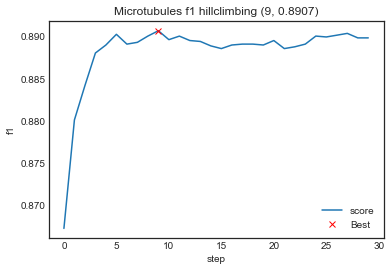

   step  midx     score             mod      f1_0
0     0     8  0.867265  se_resnext_q28  0.867265
1     1    23  0.880116          bni_u2  0.865728
2     2    11  0.884181         iv3_q12  0.864209
3     3    19  0.888046      resnet_u60  0.837488
4     4    15  0.888994      resnet_q27  0.862857
5     5    23  0.890261          bni_u2  0.865728
6     6    11  0.889100         iv3_q12  0.864209
7     7    18  0.889311      resnet_u56  0.859953
8     8     8  0.890052  se_resnext_q28  0.867265
9     9     3  0.890684      resnet_q25  0.852043

      weight             mod      f1_0
midx                                  
3          1      resnet_q25  0.852043
8          2  se_resnext_q28  0.867265
11         2         iv3_q12  0.864209
15         1      resnet_q27  0.862857
18         1      resnet_u56  0.859953
19         1      resnet_u60  0.837488
23         2          bni_u2  0.865728


hillclimbing for class 15 Microtubule ends

model 0 f1 0.5946 cut 0.5669 iv3_q11
model 1 f1 0.57

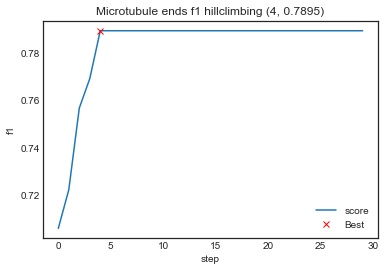

   step  midx     score         mod      f1_0
0     0    11  0.705882     iv3_q12  0.705882
1     1    17  0.722222  resnet_u31  0.666667
2     2    19  0.756757  resnet_u60  0.666667
3     3     6  0.769231     nas_q11  0.416667
4     4    17  0.789474  resnet_u31  0.666667

      weight         mod      f1_0
midx                              
6          1     nas_q11  0.416667
11         1     iv3_q12  0.705882
17         2  resnet_u31  0.666667
19         1  resnet_u60  0.666667


hillclimbing for class 16 Cytokinetic bridge

model 0 f1 0.4096 cut 0.5862 iv3_q11
model 1 f1 0.3588 cut 0.5359 irv2_q10
model 2 f1 0.3352 cut 0.5275 resnet_q24
model 3 f1 0.3216 cut 0.5338 resnet_q25
model 4 f1 0.2831 cut 0.5188 resnet_q40
model 5 f1 0.2509 cut 0.5743 gap_q12
model 6 f1 0.2089 cut 0.5111 nas_q11
model 7 f1 0.3233 cut 0.5602 se_resnext_q26
model 8 f1 0.4078 cut 0.5680 se_resnext_q28
model 9 f1 0.2990 cut 0.5245 bni_q0
model 10 f1 0.3193 cut 0.5279 bni_q1
model 11 f1 0.4487 cut 0.5834 iv3_q

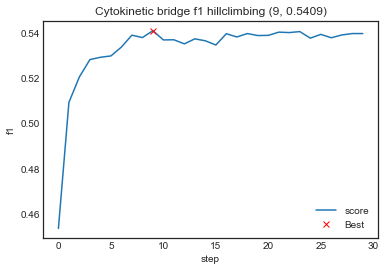

   step  midx     score             mod      f1_0
0     0    20  0.453682     resnet_u101  0.453682
1     1    11  0.509259         iv3_q12  0.448718
2     2    19  0.520516      resnet_u60  0.419214
3     3    20  0.528129     resnet_u101  0.453682
4     4    18  0.529148      resnet_u56  0.431325
5     5    22  0.529742          bni_u1  0.313433
6     6     8  0.533643  se_resnext_q28  0.407809
7     7    23  0.538895          bni_u2  0.386905
8     8     0  0.537835         iv3_q11  0.409590
9     9    23  0.540852          bni_u2  0.386905

      weight             mod      f1_0
midx                                  
0          1         iv3_q11  0.409590
8          1  se_resnext_q28  0.407809
11         1         iv3_q12  0.448718
18         1      resnet_u56  0.431325
19         1      resnet_u60  0.419214
20         2     resnet_u101  0.453682
22         1          bni_u1  0.313433
23         2          bni_u2  0.386905


hillclimbing for class 17 Mitotic spindle

model 0 f1 0.3

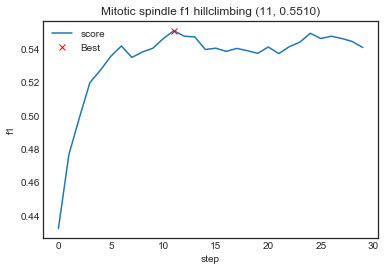

    step  midx     score         mod      f1_0
0      0    15  0.432314  resnet_q27  0.432314
1      1    17  0.476712  resnet_u31  0.336245
2      2    18  0.498778  resnet_u56  0.423256
3      3     0  0.519894     iv3_q11  0.370892
4      4    19  0.527316  resnet_u60  0.365854
5      5    14  0.535714  resnet_q26  0.386179
6      6     3  0.541872  resnet_q25  0.389722
7      7    15  0.535000  resnet_q27  0.432314
8      8     1  0.538272    irv2_q10  0.315789
9      9    15  0.540541  resnet_q27  0.432314
10    10     1  0.546366    irv2_q10  0.315789
11    11    18  0.551020  resnet_u56  0.423256

      weight         mod      f1_0
midx                              
0          1     iv3_q11  0.370892
1          2    irv2_q10  0.315789
3          1  resnet_q25  0.389722
14         1  resnet_q26  0.386179
15         3  resnet_q27  0.432314
17         1  resnet_u31  0.336245
18         2  resnet_u56  0.423256
19         1  resnet_u60  0.365854


hillclimbing for class 18 Microtubul

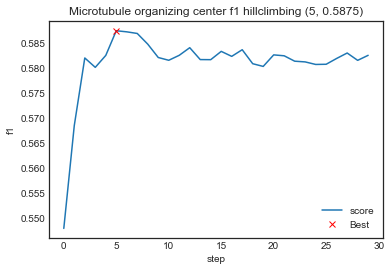

   step  midx     score         mod      f1_0
0     0    15  0.547903  resnet_q27  0.547903
1     1    19  0.568497  resnet_u60  0.514408
2     2    15  0.582016  resnet_q27  0.547903
3     3    15  0.580135  resnet_q27  0.547903
4     4    13  0.582524     iv3_u12  0.493397
5     5    11  0.587463     iv3_q12  0.475616

      weight         mod      f1_0
midx                              
11         1     iv3_q12  0.475616
13         1     iv3_u12  0.493397
15         3  resnet_q27  0.547903
19         1  resnet_u60  0.514408


hillclimbing for class 19 Centrosome

model 0 f1 0.5444 cut 0.5633 iv3_q11
model 1 f1 0.5311 cut 0.5162 irv2_q10
model 2 f1 0.5530 cut 0.5212 resnet_q24
model 3 f1 0.5522 cut 0.5168 resnet_q25
model 4 f1 0.5193 cut 0.5168 resnet_q40
model 5 f1 0.5293 cut 0.5615 gap_q12
model 6 f1 0.4852 cut 0.4922 nas_q11
model 7 f1 0.5220 cut 0.5584 se_resnext_q26
model 8 f1 0.5444 cut 0.5494 se_resnext_q28
model 9 f1 0.5431 cut 0.5222 bni_q0
model 10 f1 0.5494 cut 0.5202 bni_

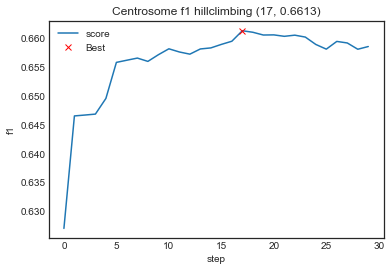

    step  midx     score         mod      f1_0
0      0    19  0.627058  resnet_u60  0.627058
1      1    15  0.646536  resnet_q27  0.558743
2      2    15  0.646689  resnet_q27  0.558743
3      3    18  0.646852  resnet_u56  0.594595
4      4    19  0.649566  resnet_u60  0.627058
5      5    11  0.655806     iv3_q12  0.569965
6      6    19  0.656183  resnet_u60  0.627058
7      7    11  0.656552     iv3_q12  0.569965
8      8    17  0.655979  resnet_u31  0.587953
9      9    19  0.657133  resnet_u60  0.627058
10    10     1  0.658158    irv2_q10  0.531106
11    11    16  0.657609  resnet_u25  0.569855
12    12    13  0.657232     iv3_u12  0.557464
13    13    19  0.658131  resnet_u60  0.627058
14    14    11  0.658314     iv3_q12  0.569965
15    15    15  0.658920  resnet_q27  0.558743
16    16    15  0.659467  resnet_q27  0.558743
17    17    16  0.661285  resnet_u25  0.569855

      weight         mod      f1_0
midx                              
1          1    irv2_q10  0.531106
1

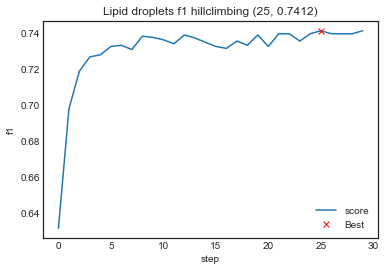

    step  midx     score          mod      f1_0
0      0    13  0.631229      iv3_u12  0.631229
1      1    17  0.697674   resnet_u31  0.591900
2      2    20  0.718750  resnet_u101  0.587097
3      3    17  0.726688   resnet_u31  0.591900
4      4    19  0.727829   resnet_u60  0.555911
5      5    15  0.732484   resnet_q27  0.532637
6      6    13  0.733119      iv3_u12  0.631229
7      7    18  0.730769   resnet_u56  0.591195
8      8    17  0.738170   resnet_u31  0.591900
9      9    19  0.737500   resnet_u60  0.555911
10    10    15  0.736196   resnet_q27  0.532637
11    11    13  0.733945      iv3_u12  0.631229
12    12    17  0.738854   resnet_u31  0.591900
13    13    12  0.737179      iv3_u11  0.556575
14    14    14  0.734824   resnet_q26  0.550820
15    15    17  0.732484   resnet_u31  0.591900
16    16    20  0.731392  resnet_u101  0.587097
17    17    19  0.735484   resnet_u60  0.555911
18    18    13  0.733119      iv3_u12  0.631229
19    19     2  0.738854   resnet_q24  0

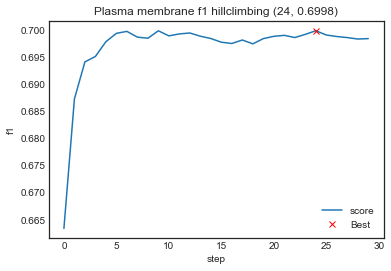

    step  midx     score             mod      f1_0
0      0    18  0.663401      resnet_u56  0.663401
1      1    11  0.687254         iv3_q12  0.660671
2      2    13  0.694082         iv3_u12  0.660253
3      3    15  0.695079      resnet_q27  0.658920
4      4    15  0.697798      resnet_q27  0.658920
5      5    20  0.699337     resnet_u101  0.651805
6      6    15  0.699699      resnet_q27  0.658920
7      7    15  0.698641      resnet_q27  0.658920
8      8    13  0.698433         iv3_u12  0.660253
9      9    21  0.699807         gap_u14  0.631922
10    10    11  0.698870         iv3_q12  0.660671
11    11    18  0.699233      resnet_u56  0.663401
12    12    16  0.699402      resnet_u25  0.641523
13    13    22  0.698811          bni_u1  0.658512
14    14     8  0.698384  se_resnext_q28  0.645342
15    15    19  0.697705      resnet_u60  0.589224
16    16    15  0.697468      resnet_q27  0.658920
17    17     0  0.698108         iv3_q11  0.646934
18    18    15  0.697404      r

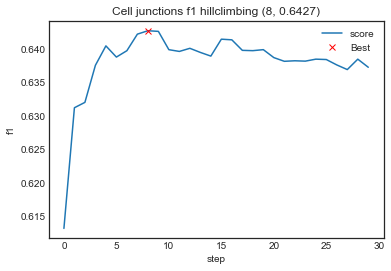

   step  midx     score             mod      f1_0
0     0    18  0.613174      resnet_u56  0.613174
1     1    16  0.631183      resnet_u25  0.589217
2     2    20  0.631985     resnet_u101  0.609238
3     3    11  0.637516         iv3_q12  0.572149
4     4    18  0.640413      resnet_u56  0.613174
5     5    20  0.638743     resnet_u101  0.609238
6     6    19  0.639697      resnet_u60  0.562384
7     7    13  0.642166         iv3_u12  0.592686
8     8     8  0.642674  se_resnext_q28  0.554692

      weight             mod      f1_0
midx                                  
8          1  se_resnext_q28  0.554692
11         1         iv3_q12  0.572149
13         1         iv3_u12  0.592686
16         1      resnet_u25  0.589217
18         2      resnet_u56  0.613174
19         1      resnet_u60  0.562384
20         2     resnet_u101  0.609238


hillclimbing for class 23 Mitochondria

model 0 f1 0.7887 cut 0.5687 iv3_q11
model 1 f1 0.7806 cut 0.5187 irv2_q10
model 2 f1 0.7850 cut 0.5192 re

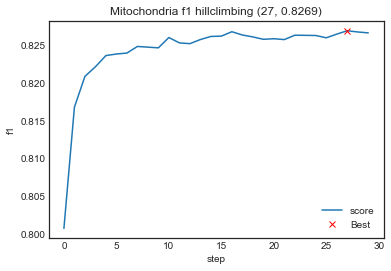

    step  midx     score          mod      f1_0
0      0    13  0.800761      iv3_u12  0.800761
1      1    17  0.816799   resnet_u31  0.783793
2      2    18  0.820875   resnet_u56  0.798285
3      3    15  0.822149   resnet_q27  0.793827
4      4    20  0.823631  resnet_u101  0.792117
5      5    11  0.823837      iv3_q12  0.785972
6      6    12  0.823962      iv3_u11  0.794600
7      7    19  0.824837   resnet_u60  0.777623
8      8    19  0.824746   resnet_u60  0.777623
9      9    15  0.824654   resnet_q27  0.793827
10    10    15  0.826020   resnet_q27  0.793827
11    11    17  0.825310   resnet_u31  0.783793
12    12    16  0.825206   resnet_u25  0.793940
13    13    15  0.825750   resnet_q27  0.793827
14    14    13  0.826161      iv3_u12  0.800761
15    15    15  0.826206   resnet_q27  0.793827
16    16    19  0.826785   resnet_u60  0.777623
17    17    16  0.826356   resnet_u25  0.793940
18    18    19  0.826102   resnet_u60  0.777623
19    19    17  0.825785   resnet_u31  0

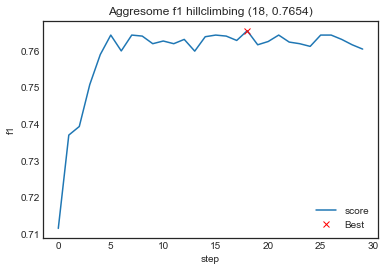

    step  midx     score         mod      f1_0
0      0    13  0.711599     iv3_u12  0.711599
1      1    15  0.737013  resnet_q27  0.661515
2      2    21  0.739353     gap_u14  0.684882
3      3    10  0.750779      bni_q1  0.673367
4      4    21  0.758942     gap_u14  0.684882
5      5    15  0.764253  resnet_q27  0.661515
6      6    17  0.759936  resnet_u31  0.604027
7      7    12  0.764253     iv3_u11  0.682676
8      8     2  0.763975  resnet_q24  0.624294
9      9    18  0.761905  resnet_u56  0.695385
10    10    15  0.762634  resnet_q27  0.661515
11    11     0  0.761905     iv3_q11  0.687285
12    12     1  0.763077    irv2_q10  0.639344
13    13    23  0.759878      bni_u2  0.677914
14    14    15  0.763804  resnet_q27  0.661515
15    15    12  0.764253     iv3_u11  0.682676
16    16    21  0.763975     gap_u14  0.684882
17    17     4  0.762791  resnet_q40  0.639241
18    18    15  0.765432  resnet_q27  0.661515

      weight         mod      f1_0
midx                    

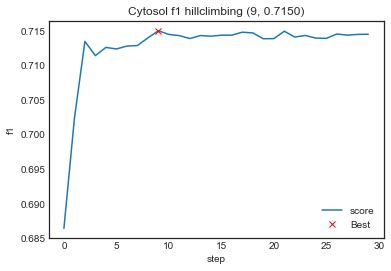

   step  midx     score         mod      f1_0
0     0    15  0.686423  resnet_q27  0.686423
1     1    19  0.702314  resnet_u60  0.666161
2     2    11  0.713446     iv3_q12  0.684675
3     3    18  0.711400  resnet_u56  0.677617
4     4    17  0.712588  resnet_u31  0.676512
5     5    11  0.712358     iv3_q12  0.684675
6     6    19  0.712774  resnet_u60  0.666161
7     7    15  0.712855  resnet_q27  0.686423
8     8    13  0.713952     iv3_u12  0.669506
9     9    19  0.714992  resnet_u60  0.666161

      weight         mod      f1_0
midx                              
11         2     iv3_q12  0.684675
13         1     iv3_u12  0.669506
15         2  resnet_q27  0.686423
17         1  resnet_u31  0.676512
18         1  resnet_u56  0.677617
19         3  resnet_u60  0.666161


hillclimbing for class 26 Cytoplasmic bodies

model 0 f1 0.4169 cut 0.6060 iv3_q11
model 1 f1 0.3909 cut 0.5378 irv2_q10
model 2 f1 0.4180 cut 0.5327 resnet_q24
model 3 f1 0.4428 cut 0.5270 resnet_q25
model 4 f1

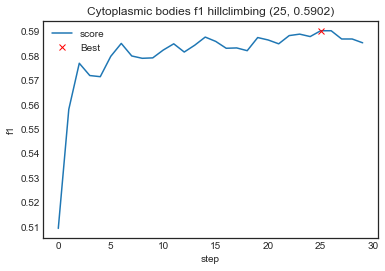

    step  midx     score          mod      f1_0
0      0    18  0.509375   resnet_u56  0.509375
1      1    17  0.558065   resnet_u31  0.493789
2      2    15  0.576923   resnet_q27  0.472180
3      3    14  0.571901   resnet_q26  0.430647
4      4    17  0.571429   resnet_u31  0.493789
5      5    20  0.579760  resnet_u101  0.490818
6      6    10  0.585034       bni_q1  0.421333
7      7    22  0.579901       bni_u1  0.426332
8      8    17  0.578947   resnet_u31  0.493789
9      9     4  0.579125   resnet_q40  0.430345
10    10    19  0.582322   resnet_u60  0.427762
11    11    14  0.584874   resnet_q26  0.430647
12    12    15  0.581513   resnet_q27  0.472180
13    13    17  0.584307   resnet_u31  0.493789
14    14    20  0.587629  resnet_u101  0.490818
15    15     3  0.585859   resnet_q25  0.442815
16    16    17  0.583051   resnet_u31  0.493789
17    17    10  0.583190       bni_q1  0.421333
18    18    18  0.582064   resnet_u56  0.509375
19    19    15  0.587436   resnet_q27  0

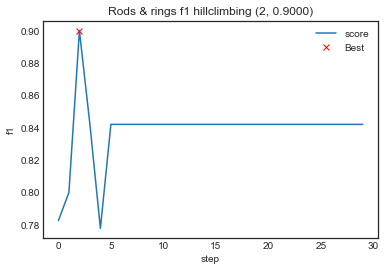

   step  midx     score         mod      f1_0
0     0    13  0.782609     iv3_u12  0.782609
1     1    19  0.800000  resnet_u60  0.761905
2     2    10  0.900000      bni_q1  0.600000

      weight         mod      f1_0
midx                              
10         1      bni_q1  0.600000
13         1     iv3_u12  0.782609
19         1  resnet_u60  0.761905

overall mean f1 0.7588161950566005  mean cut 0.5259412727686452   mean steps 12.892857142857142


<Figure size 432x288 with 0 Axes>

In [600]:
# hillclimbing separately for each class

# vp = oof.copy()
# offset = 5
# nm = vp.shape[1] - offset
nr = vp.shape[0]
y = np.array([y for y in vp.y])
# y = np.array(list(vp['masks'].values))
nstep = 30

step0fix = -1
# step0fix = 5
step1fix = -1

intercept = 0

metric = 'f1'
# metric = 'iou'

# threshold = 0.
# threshold = 0.36
# threshold = 0.5
# print('using ' + metric + ' threshold',threshold)

# metric = "mcc"
# metric = "corr"
# metric = "rmse"
# metric = "mse"
# metric = "mae"
# metric = "winsorized_mae"
# metric = "auc"

cut_mets = ['mcc','f1']
bestCut = threshold

num_classes = 28

rez_all = []
tb_all = []
bestEnsemble_all = []
bestStep_all = []
bestScore_all = []
bestCut_all = []

for c in range(num_classes):
    
    print()
    print()
    print('hillclimbing for class',c,LABEL_MAP[c])
    print()

    rez = pd.DataFrame({'step':np.zeros(nstep).astype(int),'midx':np.zeros(nstep).astype(int),
                        'score':np.zeros(nstep)})
    currEnsemble = 0 * np.array(list(vp.iloc[:,offset].values))

    # maximizing
    bestScore = -9999999
    single = pd.DataFrame({'mod':np.repeat("",nm)})
    start = 0
    for step in range(start,nstep):
        single[metric+'_'+str(step)] = np.nan

    for step in range(start,nstep):
        currIndex = 0
        currScore = -9999999

        for i in range(nm):

            mname = vp.columns[i+offset]

            tv = np.array(list(vp.iloc[:,offset+i].values))

            # mean-center
    #         tv = tv - np.mean(tv)

            # adjust by model-specific threshold
    #         tv = tv - mthresh[mname]

            # adjust by model-class-specific thresholds
    #         for j in range(tv.shape[1]):
    #             tv[:,j] = tv[:,j] - cthresh[mname][j]

            if np.sum(np.isnan(tv)) > 0: continue

            if step==0:
                tryEnsemble = tv
            else:
                # running mean
                tryEnsemble = (step * currEnsemble + tv)/(step+1)
                # full matrix
                # choose median or mean here
                # tryEnsemble = rowMedians(cbind(currEnsemble,tv))
                # tryEnsemble = rowMeans(cbind(currEnsemble,tv))
                # quantiles are a lot slower
                # tryEnsemble = rowQuantiles(cbind(currEnsemble,tv),probs=0.6)

            if metric=="f1":
                # estimate new class-specific thresholds by line search, slow
                cut = fit_val1(tryEnsemble[:,c],y[:,c])
                tryScore = f1_score(y[:,c], np.int32(tryEnsemble[:,c] > cut))

#                 # estimate new class-specific thresholds to match proportions, medium
#                 th = fit_val2(tryEnsemble[:,c],y[:,c])
#                 tryScore = f1_score(y[:,c], np.int32(tryEnsemble[:,c] > th))

#                 # fixed threshold, fast
#                 tryScore = f1_score(y[:,c], np.int32(tryEnsemble[:,c] > threshold))

#                 if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
            elif metric=="iou":
                tryScore = iou_metric_batch(y, np.int32(tryEnsemble > threshold),
                                            pred_eps=pred_eps)
                if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
            elif metric=="mse":
                tryScore = -mse(y,tryEnsemble)
            elif metric=="mae": 
                tryScore = -mae(y,tryEnsemble)
            elif metric=="winsorized_mae": 
                tryScore = -winsorized_mae(y,tryEnsemble+intercept)
            elif metric=="rmse":
                tryScore = -rmse(y,tryEnsemble)
            elif metric=="corr":
                tryScore = cor(y,tryEnsemble)
            elif metric=="mcc":
                opt = eval_mcc3(y,tryEnsemble,cut=T)
                tryScore = opt[1]
                cut = opt[2]
                # opt = optimize(mcc,c(0.1,0.3),tryEnsemble,vp$y,maximum=T)
                # tryScore = opt$objective
            elif metric=="logloss":
                # tryScore = -logLoss(vp$y,tryEnsemble,)
                tryScore = -eval_logloss2(tryEnsemble,y)
            elif metric=="auc":
                tryScore = auc2(y,tryEnsemble)
            elif metric=="auprc":
                tryScore = auprc(tryEnsemble, y)
                # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.davis.goadrich
            elif metric=="aurocpr":
                auroc = auc(y,tryEnsemble)
                # auprc = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                tryScore = (auroc + auprc)/2
            elif metric=="sqwk":
                tryScore = sqwk(y,tryEnsemble,1,8)

            ok = 1
            if (step==0) and (step0fix>-1) and (i!=step0fix): ok = 0 
            if (step==1) and (step1fix>-1) and (i!=step1fix): ok = 0 

            if (tryScore > currScore) and (ok==1):
                currIndex = i
                currScore = tryScore
                if (step==0):
                    saveEnsemble = tv.copy()
                else:
                    # running mean
                    saveEnsemble = tryEnsemble.copy()
                    # save whole matrix
                    # saveEnsemble = np.concatenate((currEnsemble,tv),axis=1)
                if metric in cut_mets: currCut = cut

            # if (step==0) or ((step==1) and (step0fix>-1)) or ((step==2) and (step1fix>-1)):
            if (step==0):
                if metric in cut_mets:
                    print("model",i,metric,"%6.4f" % tryScore,
                          "cut %6.4f" % cut, vp.columns[i+offset])
                else:
                    print("model",i,metric,"%6.4f" % tryScore, vp.columns[i+offset])

            if step==0:
                single.loc[i,'mod'] = vp.columns[i+offset]  
            single.iloc[i,step+1] = tryScore

        if metric in cut_mets:
            print("step =", step,"  ", metric,"= %6.4f" % currScore,
                  "  cut = %6.4f" % currCut,"  name =", vp.columns[currIndex+offset])
        else:
            print("step =",step,"  ", metric,"= %6.4f" % currScore,
                  "  name =", vp.columns[currIndex+offset])

        currEnsemble = saveEnsemble.copy()
        if currScore > bestScore:
            bestScore = currScore
            bestStep = step
            bestEnsemble = currEnsemble.copy()
            if metric in cut_mets: bestCut = currCut

        rez.iloc[step,0] = step
        rez.iloc[step,1] = currIndex
        rez.iloc[step,2] = currScore

    if metric in cut_mets:
        print("best step =",bestStep,"  best",metric,"= %6.4f" % bestScore,
              "  best cut = %6.4f" % bestCut)
    else:
        print("best step =",bestStep,"  best",metric,"= %6.4f" % bestScore)

    rez0 = rez.copy()

    # tb = table(rez$index[1:bestStep])
    # names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

    # if (intercept!=0) {
    #   tb["Intercept"] = intercept
    # }

    # print(tb[order(-tb)])
    # print(single[order(-single[,2]),][1:min(nrow(single),40),])

    # plot hillclimbing
    print('')
    plt.plot(rez0.step, rez0.score)
    plt.plot(bestStep, bestScore, "xr", label="Best")
    plt.xlabel("step")
    plt.ylabel(metric)
    plt.title(LABEL_MAP[c] + " " + metric + " hillclimbing (%d, %6.4f)" % (bestStep, bestScore))
    plt.legend()
    plt.show()
    plt.gcf().clear()

    # display the weights
    rez = rez.iloc[:(bestStep+1)]
    # print(rez)

    single0 = single.iloc[:,:2]

    rez['midx'] = rez['midx'].astype(int)
    rez = rez.join(single0,how='left',on='midx')
    print(rez)
    print('')

    rez['weight'] = 1
    tb = rez.loc[:,['midx','weight']].groupby('midx').count()
    # print(tb)
    # print(single)

    tb = tb.join(single0,how='left')
    print(tb)
    
    rez_all.append(rez)
    tb_all.append(tb)
    bestEnsemble_all.append(bestEnsemble)
    bestStep_all.append(bestStep)
    bestScore_all.append(bestScore)
    bestCut_all.append(bestCut)

print()
print('overall mean f1',np.mean(bestScore_all),' mean cut',np.mean(bestCut_all),
      '  mean steps',np.mean(bestStep_all))

In [601]:
print('mean f1',np.mean(bestScore_all),' mean cut',np.mean(bestCut_all),
      '  mean steps',np.mean(bestStep_all))

mean f1 0.7588161950566005  mean cut 0.5259412727686452   mean steps 12.892857142857142


In [602]:
# tb_all

In [603]:
midx = str(midx)
fname = 'ens_weights'+midx+'.pkl'
pickle.dump(tb_all,open(fname,'wb'))
print(fname)

ens_weights56.pkl


In [604]:
for i in range(28):
    tb_all[i]['class'] = i
tba = pd.concat(tb_all).reset_index()
print(tba.shape)

(193, 5)


In [605]:
tba.head()

midx  weight         mod      f1_0  class
0    11       2     iv3_q12  0.823880      0
1    13       1     iv3_u12  0.819621      0
2    15       4  resnet_q27  0.821979      0
3    18       1  resnet_u56  0.825270      0
4    19       3  resnet_u60  0.813495      0

In [606]:
# show most popular models
tbag = tba.groupby('mod')
ws = pd.DataFrame(tbag['weight'].sum())
ws.columns = ['ws']
ws.sort_values(['ws'],ascending=False,inplace=True)
print(ws)

                ws
mod               
resnet_q27      62
resnet_u60      61
resnet_u31      45
iv3_q12         37
resnet_u56      37
iv3_u12         29
resnet_u101     28
resnet_u25      13
iv3_u11         12
resnet_q26      11
bni_u2           8
se_resnext_q28   6
irv2_q10         5
iv3_q11          5
resnet_q40       5
bni_q1           4
bni_u1           4
resnet_q24       4
gap_u14          4
resnet_q25       4
nas_q11          3
se_resnext_q26   2


In [607]:
bestCut_all

[0.5390768849025263,
 0.5342855431102206,
 0.5416192879616447,
 0.5259276283138964,
 0.5390353350558158,
 0.5311180813976154,
 0.5353723500222631,
 0.5253412079052001,
 0.5065982123112837,
 0.49239025572116557,
 0.4881483582575904,
 0.5272281253759272,
 0.545818542636954,
 0.547538269148449,
 0.5652677932747753,
 0.4731928465478052,
 0.5454439407029983,
 0.5214533436751384,
 0.5382303724873355,
 0.5298925421616631,
 0.5093957585510621,
 0.5315852292204446,
 0.5458860035491657,
 0.5225412431606209,
 0.5232151366563969,
 0.5325593434027732,
 0.515798142921918,
 0.492395859089417]

In [608]:
f1_score(y[:,9],y[:,10])

0.7671232876712328

In [609]:
confusion_matrix(y[:,9],y[:,10])

array([[31027,     0],
       [   17,    28]])

In [610]:
########  OLD CODE BELOW HERE ###########

# best possible score
np.mean(np.max(ioua,axis=0))

NameError: name 'ioua' is not defined

In [ ]:
am = (am + am2) // 2
print(am.shape)
print(am[:50])

In [ ]:
train_df['best_thresh'] = [thresholds[a] for a in am]
train_df['pred_mean'] = [np.mean(b) for b in bestEnsemble]
train_df['pred_std'] = [np.std(b) for b in bestEnsemble]
train_df['pred_min'] = [np.min(b) for b in bestEnsemble]
train_df['pred_max'] = [np.max(b) for b in bestEnsemble]
train_df['image_mean'] = [np.mean(b) for b in train_df.images]
train_df['image_std'] = [np.std(b) for b in train_df.images]
print(train_df.shape)

In [ ]:
fname = 'best_thresh.csv'
train_df.to_csv(fname)
print(fname)

In [ ]:
# predict best threshold with bootstrap forest in jmp
btp = pd.read_csv('btp.csv')
# btp = pd.read_csv('btp2.csv')
print(btp.head())
print(btp.shape)

In [ ]:
btpa = btp.btp.values

In [ ]:
ioub = np.array([iou_metric(m, np.int32(b > (t + 0.1)), pred_eps=pred_eps) \
                 for m, b, t in zip(train_df.masks, bestEnsemble, btpa)])

print(np.mean(ioub))

In [ ]:
# threshold_best_index = np.argmax(ious[9:-10]) + 9
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('')
print('iou_best',iou_best)
print('threshold_best',threshold_best)
print('')

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()
plt.show()
plt.gcf().clear()

In [ ]:
# compute best epsilon threshold for computed ensemble, still on logit scale
peps = np.array([1e-12, 0.00001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01])
ious = np.array([iou_metric_batch(train_df.masks, np.int32(bestEnsemble > threshold_best),
                                  pred_eps=e) for e in peps])

# threshold_best_index = np.argmax(ious[9:-10]) + 9
eps_best_index = np.argmax(ious)
iou_best = ious[eps_best_index]
eps_best = peps[eps_best_index]
print('')
print('iou_best',iou_best)
print('eps_best',eps_best)
print('')

plt.plot(peps, ious)
plt.plot(eps_best, iou_best, "xr", label="Best epsilon")
plt.xlabel("Epsilon")
plt.ylabel("IoU")
plt.title("IOU vs Prediction Epsilon ({}, {})".format(iou_best, eps_best))
plt.legend()
plt.show()
plt.gcf().clear()

In [ ]:
ious

In [ ]:
v = [(np.mean(mask),np.mean(pred)) for mask,pred in zip(train_df.masks,
        np.int32(bestEnsemble > threshold_best))]

In [ ]:
v0 = [(a,b) for a,b in v if a == 0.0 and b > 0.5]

In [ ]:
v0

In [ ]:
v[:20]

In [ ]:
# Error analysis
ioum, ioub = iou_metric_batch(train_df.masks, np.int32(bestEnsemble > threshold_best), \
                              pred_eps=eps_best, return_all=True)
ioub = np.array(ioub)
print(ioub.min(),ioub.mean(),ioub.max())

sns.distplot(ioub)
plt.title("Distribution of OOF IOU Scores")
plt.show()
plt.gcf().clear()

train_df['ens'] = [bestEnsemble[i] for i in range(poof.shape[0])]

train_df['ensb'] = [np.array(bestEnsemble[i] > threshold_best) for i in range(poof.shape[0])]

train_df['pcov'] = [np.array(bestEnsemble[i] > threshold_best).mean() for i in range(poof.shape[0])]

train_df['ioub'] = ioub
print(train_df.columns)
print(train_df.shape)

ct = train_df.loc[:,['z','coverage','coverage_class','ioub']]
print(ct.groupby('coverage_class').mean())
print(ct.groupby('ioub').mean())

# plot coverage
print('')
plt.plot(train_df.pcov, train_df.coverage, 'ro')
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("Observed Salt Coverage")
plt.title("Observed vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()

print('')
# plt.plot(train_df.pcov, train_df.ioub, 'ro')
sns.regplot(train_df.pcov, train_df.ioub, lowess=True)
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("IOU")
plt.title("IOU vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()

print('corr',train_df.loc[:,['ioub','coverage','pcov']].corr())

# plot validation images with scores
# sort from worst to best then by salt coverage
train_dfs = train_df.sort_values(['ioub','coverage','pcov'],ascending=[True,True,False])

start = 0
stop = 500
# grid_width = 10
# grid_height = int(max_images / grid_width)
# print(max_images,grid_height,grid_width)
ni = 10

# show worst fitting images
for j in range(int(start/10),int(stop/10)):
    jj = j*10
    fig, axs = plt.subplots(2, ni, figsize=(20,4))
    for i in range(ni):
        img = train_dfs.iloc[jj+i].images
        mask = train_dfs.iloc[jj+i].masks
        pred = train_dfs.iloc[jj+i].ensb
        iou = train_dfs.iloc[jj+i].ioub
        cov = train_dfs.iloc[jj+i].coverage
        pcov = train_dfs.iloc[jj+i].pcov
        axs[0][i].imshow(img, cmap="Greys")
        axs[1][i].imshow(img, cmap="Greys")
        axs[1][i].imshow(mask, alpha=0.3, cmap="Greens")
        axs[1][i].imshow(pred, alpha=0.3, cmap="OrRd")
        axs[0][i].set_title(str(iou) + ' ' + str(np.round(cov,4)) + ' ' + str(np.round(pcov,4)))
    fig.suptitle("Top row: original, bottom row: true salt green, predicted red")
    plt.show()
    plt.gcf().clear()

In [ ]:
print('')
sns.regplot(train_df.pcov, train_df.ioub, lowess=True)
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("IOU")
plt.title("IOU vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()

In [ ]:
# offset = 3
# nm = oof.shape[1] - offset
# print(offset, oof.shape, nm)

# oof.head()

# np.array(list(oof.iloc[:,3])).shape

# # simple mean ensemble over all models
# first = True
# for i in range(offset,offset+nm):
#     print(i)
#     p = np.array(list(oof.iloc[:,i].values))/nm
#     if first: 
#         ens = p
#         first = False
#     else: ens += p
# print(ens.shape)

# sns.distplot(ens.flatten())
# plt.show()
# plt.gcf().clear()

In [ ]:
d3 = train_df.loc[:,['ioub','coverage','pcov']]
# print(d3.shape)
d3q = d3.query('(coverage == 0.0) & (pcov >= 1e-6)')
print(d3q.shape)
print(d3q.describe())
print(d3q)

In [ ]:
# print(d3.shape)
d0 = d3.query('(ioub == 0.0)')
print(d0.describe())
print(d0.shape)
# print(d0)

In [ ]:
# IOU = 0 values
print('')
plt.plot(d0.pcov, d0.coverage, 'ro')
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("Observed Salt Coverage")
plt.title("IOU = 0, Observed vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()


In [ ]:
ens = np.int32(bestEnsemble > threshold_best)
iou_metric_batch(train_df.masks, ens, pred_eps=eps_best)

In [ ]:
# average pixel accuracy
ens_cut = []
for e in ens:
    cov = np.mean(e)
    if cov <= pred_eps: e *= 0
    ens_cut.append(e)
    
acc = [np.mean(gt == e) for (gt,e) in zip(train_df.masks,ens_cut)]
print(np.mean(acc))

In [ ]:
# binary cross entropy
from scipy.special import expit
ce = [-np.mean((gt < 0.5)*np.log(1.0 - expit(e)) + (gt > 0.5)*np.log(expit(e))) \
      for (gt,e) in zip(train_df.masks,bestEnsemble)]
print(np.mean(ce))

In [ ]:
np.sum(bestEnsemble > 10.)

In [ ]:
# show max logits for each model, jackie becomes inf with eps <= 1e-4, np.clip does not work on upper bound
scols = ['z','coverage','coverage_class','fold']
mcols = [c for c in oof if c not in scols]
for c in mcols:
    print(c,np.array([m.max() for m in oof[c]]).max())

In [ ]:
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    # if str(df.loc[i,'rle_mask'])!=str(np.nan):        
    if True:        
        # decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        plt.subplot(1,6,j+1)
        # plt.imshow(decoded_mask)
        plt.imshow(ens[i])
        plt.title('ID: '+train_df.index.values[i])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [ ]:
# crf kaggle kernel
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     # Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    # Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    # Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [ ]:
ens_crf = []
for i in range(train_df.shape[0]):
    ens_crf.append(crf(train_df.masks[i],ens[i]))
    if i % 1000 == 0: print(i)
ens_crf = np.array(ens_crf)  

In [ ]:
iou_metric_batch(train_df.masks,ens_crf,pred_eps=eps_best)

In [ ]:
print(tb)

In [ ]:
oof.shape

In [ ]:
oof.columns

In [ ]:
folds = pd.read_csv('folds.csv')
print(folds.head())
print(folds.shape)

In [ ]:
oof = oof.join(folds.set_index('id'),how='left')
print(oof.columns)

In [ ]:
scols = ['z','coverage','coverage_class','fold']
mcols = [c for c in oof if c not in scols]
print(oof.loc[:,scols].describe())

In [ ]:
d = 101
s = oof.loc[:,scols]
ss = pd.concat([s]*(d*d))
print(ss.head())
print(ss.shape)

m = np.array(oof.loc[:,mcols])
print(m.shape)

In [ ]:
# pull out 10 x 10 central crop as a small test case
small = oof.copy()
for c in mcols:
    # small[c] = [cc[45:55,45:55] for cc in small[c]]
    small[c] = [cc[5:100:10,5:100:10] for cc in small[c]]
print(small.shape)

In [ ]:
d = 10
s = small.loc[:,scols]
ss = pd.concat([s]*(d*d))
print(ss.head())
print(ss.shape)

m = np.array(small.loc[:,mcols])
print(m.shape)

In [ ]:
m = np.array([np.array(list(i)) for i in m])
print(m.shape)

In [ ]:
m = m.transpose((2,3,0,1))
print(m.shape)

In [ ]:
m = m.reshape((-1,m.shape[-1]))
print(m.shape)

In [ ]:
md = pd.DataFrame(m)
md.columns = mcols
print(md.shape)

In [ ]:
sr = ss.reset_index()
f = pd.concat((sr,md),axis=1)
print(f.shape)

In [ ]:
print(f.columns)

In [ ]:
print(f['id'].head())

In [ ]:
print(f.loc[:,['z','coverage','coverage_class','fold','images','masks','si0c20']].describe())

In [ ]:
# fname = 'small_stack0.csv'
# fname = 'small_stack1.csv'
# fname = 'small_stack2.csv'
fname = 'small_stack3.csv'
f.to_csv(fname)
print(fname)

In [ ]:
ldf.head()

In [ ]:
logit[:4]

In [ ]:
ldf.drop('logit_xception_o0',inplace=True,axis=1)

m = 'xception_o0'
for j in range(3):
    ldf[m+'_logit_'+str(j)] = [a for a in logit[:,j]]

ldf.head()

ldf.set_index('id',inplace=True)

train_df = train_df.join(ldf)

In [ ]:
train_df.columns